# Importar Bibliotecas

In [3]:
import os
os.listdir(r'./Arquivos SSP/bancos_auxiliares')

['bkp',
 'bnb_model.sav',
 'df_SP_Square_ID.parquet',
 'feriados_SP.csv',
 'Fonte.txt',
 'gnb_model.sav',
 'gscv_GBC_model.sav',
 'gscv_RFC.sav',
 'gscv_RL.sav',
 'mlp_model.sav',
 'municipios_geo.csv',
 'SP_population.txt',
 'square_qty_map.parquet']

In [2]:
import pandas as pd
import json
import numpy as np
import random
import datetime
import os
from scipy import stats
from math import radians, cos, sin, asin, sqrt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # Teste para série estacionária
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.arima.model import ARIMA

import geopandas as gpd
from shapely.geometry import Point,Polygon
import pyproj

import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# https://plotly.com/python/3d-scatter-plots/

from bokeh.plotting import figure, show, gmap
from bokeh.tile_providers import get_provider,STAMEN_TERRAIN, OSM # https://docs.bokeh.org/en/latest/docs/reference/tile_providers.html
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, LabelSet,LogColorMapper,
                          GeoJSONDataSource, HoverTool, GMapOptions,
                          LinearColorMapper, Slider, DateRangeSlider, LogTicker)
from bokeh.io import output_notebook, reset_output, export_png
from bokeh.layouts import column, row, widgetbox
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256,brewer
from bokeh.models.widgets import RangeSlider

import folium
from folium.plugins import HeatMap

sns.set_style("darkgrid")

bold   = "\033[1m"
unbold = "\033[0m"

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

DF_TRATADO_PARQUET_FOLDER = r"./Arquivos SSP\bancos_auxiliares\bkp/"
EXPORT_CHARTS_TCC         = r'./Graficos e Prints/'
BANCOS_AUXILIARES         = r'./Arquivos SSP\bancos_auxiliares/'
VERBOSE                   = True

# Funções

## tratar_acentos

In [3]:
def tratar_acentos(string):
    '''
        Padronizar strings: Sem acentos, maiúsculo
    '''
    if isinstance(string,str):
        string = string.lower()

        acentos_dict = {'a':['á','à','â','ã','ä'],
                        'e':['é','è','ê','ë'],
                        'i':['í','ì','î','ï'],
                        'o':['ó','ò','ô','õ','ö'],
                        'u':['ú','ù','û','ü'],
                        'c':['ç'],
                        'd ':["d'"],# 'APARECIDA D OESTE', "APARECIDA D'OESTE",
                       }

        for key, value_list in acentos_dict.items():
            for acento in value_list:
                string = string.strip().replace(acento,key)

        return string.upper()
    else:
        return string

## Função de Plot Bokeh

In [4]:
def plot_bokeh_lat_lon(df,TOOLTIPS,lon_col,lat_col,size_col=8,alpha=0.6,fill_color='cyan'):
    
    df_plot = df.copy()
    
    #FUNCTION TO CONVERT GCS WGS84 TO WEB MERCATOR
    def wgs84_web_mercator_point(lon,lat):
        
        k = 6378137
        x= lon * (k * np.pi/180.0)
        y= np.log(np.tan((90 + lat) * np.pi/360.0)) * k
        return x,y

    #DATA FRAME
    def wgs84_to_web_mercator(df1, lon, lat):
        
        df = df1.copy()
        
        k = 6378137
        df[lon+"_mercator"] = df[lon] * (k * np.pi/180.0)
        df[lat+"_mercator"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
        return df
    
    
    df_plot = wgs84_to_web_mercator(df_plot, lon = lon_col, lat = lat_col)

    lon_min,lat_min = df_plot[lon_col].min() , df_plot[lat_col].min()
    lon_max,lat_max = df_plot[lon_col].max() , df_plot[lat_col].max()
    
    #COORDINATE CONVERSION
    xy_min = wgs84_web_mercator_point(lon_min,lat_min)
    xy_max = wgs84_web_mercator_point(lon_max,lat_max)
    
    
    output_notebook()
    
    # TOOLTIPS = [
        # ("CIDADE: ", "@Cidade"),
        # ('Eventos Criminosos','@Eventos_Criminosos'),
        # ('Populacao', "@Populacao"),
        # ("Indice de eventos por 1000 hab", "@Eventos_Criminosos_1000_hab"),
    # ]
    
    #Create random HEX Color
    r = lambda: random.randint(0,255)
    # print('#%02X%02X%02X' % (r(),r(),r()))
    
    if fill_color in df_plot.columns:
        column_categories_colors = df_plot[fill_color].groupby(df_plot[fill_color]).apply(lambda x: '#%02X%02X%02X' % (r(),r(),r()))
        df_plot = df_plot.join(column_categories_colors,on=fill_color,rsuffix='_r')
        fill_color = fill_color + '_r'
    
    if isinstance(size_col,str):
        try:
            # configure sizes:
            df_plot['circle_sizes'] = round(stats.zscore(df_plot[size_col])+4,2)*4
        except:
            df_plot['circle_sizes'] = size_col            
    else:
        df_plot['circle_sizes'] = size_col
    
    
    #FIGURE SETTING
    x_range,y_range = ([xy_min[0], xy_max[0]] , [xy_min[1], xy_max[1]])
    
    p               = figure(x_range = x_range, y_range = y_range,
                             x_axis_type='mercator',y_axis_type='mercator',
                             sizing_mode='scale_width',
                             plot_height=300,
                             plot_width = 800,
                             tooltips = TOOLTIPS)
    
    #PLOT BASEMAP AND AIRPLANE POINTS
    flight_source = ColumnDataSource(df_plot)
    tile_prov=get_provider(OSM)
    p.add_tile(tile_prov,level='image')
    
    palette = Turbo256
    p.circle(lon_col+"_mercator",
             lat_col+"_mercator",
             source=flight_source,
             hover_color='yellow',
             size='circle_sizes',
             fill_alpha=alpha,
             line_alpha=alpha,
             fill_color=fill_color)
    
    p.xaxis.axis_label = 'longitude'
    p.yaxis.axis_label = 'latitude'
    
    show(p)

## Time Series Função de Decomposição

In [5]:
def decomposition_ts(df_decomp,decomposition_type="multiplicative",period=12,cidade=None):
    
    decompose_result_mult = seasonal_decompose(df_decomp,
                                               model  = decomposition_type,
                                               period = period)
    
    trend    = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid
    
    ax = decompose_result_mult.plot();
    
    ax.figure.set_figheight(10)
    ax.figure.set_figwidth(20)
    ax.figure.suptitle(f"DF {cidade}- DECOMPOSITION: " + decomposition_type)

## Função de Autocorrelação e Autocorrelação Parcial de Time Series

In [6]:
def plot_acf_pacf(df,
                  nrows,
                  filtros_lista=[],
                  time_id_col=None,
                  figsize=(15,20),
                  cidade = None,
                  lags   = 10,
                 ):
    '''
    Função para plotar Autocorrelation Funtion e Partial Autocorrelation Function
    
    <args>:
        filtros_lista: cidade e/ou (pandemia ou ~pandemia)
    
    '''
    
    if filtros_lista is not None:
        filtros_lista = [str(i).lower() for i in filtros_lista]
    
    if 'cidade' in filtros_lista:
        print("Filtro Cidade")    
    if 'pandemia' in filtros_lista:
        print("Filtro Pandemia")
    elif '~pandemia' in filtros_lista:
        print("Filtro ~Pandemia")
    
    
    fig,axs = plt.subplots(nrows=nrows,ncols=2,figsize=figsize)
    
    for i,ax in enumerate(axs.reshape(-1)): 
        
        # FILTROS: 
        if 'cidade' in filtros_lista:
            cidade          =  df['CIDADE'].unique()[round((i-0.001)/2)]
            filtro_cidade   = (df['CIDADE'] == cidade)
        elif time_id_col is not None:
            cidade = 'Dados Completos'
            filtro_cidade = (df.assign(filtro_dummy=True)['filtro_dummy'])
        
        if 'pandemia' in filtros_lista:
            filtro_pandemia = (time_series_to_decomp['PANDEMIA'])

        elif '~pandemia' in filtros_lista:
            filtro_pandemia = ~(time_series_to_decomp['PANDEMIA'])
        elif time_id_col is not None:
            filtro_pandemia = (df.assign(filtro_dummy=True)['filtro_dummy'])
            
        if time_id_col is not None:
            df_acf = df.loc[filtro_cidade & filtro_pandemia].set_index('time_id')['value']
        else:
            df_acf = df.copy()
        
        if i%2==0:
            plot_acf(df_acf,
                     title ='ACF - '+ cidade,
                     lags  = lags,
                     zero  = False,
                     ax    = ax)
        else:
            plot_pacf(df_acf,
                      title  = 'PACF - '+ cidade,
                      lags   = lags,
                      zero   = False,
                      method = 'ywm',
                      ax     = ax)
    
    plt.tight_layout()
    plt.show()

In [6]:
def criar_grade_cidades(canto_inferior_esquerdo,canto_superior_esquerdo,canto_superior_direito,canto_inferior_direito):
    
    """
    Esta função cria uma grade com quadrados de 5km² a partir do mapa do município desejado
    
    <args>:
        Coordenadas do envelope do mapa da cidade (cantos extremos, nomeados de forma autoexplicativa)
    """
    
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calcular a distância entre dois pontos na superfície do planeta Terra (input em graus)
        """
        # converte graus para radianos
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
        # formula haversine  
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Valor do raio da Terra em quilômetros
        return c * r

    distancia_longitudinal = haversine(lon1=canto_superior_esquerdo[0], lat1=canto_superior_esquerdo[1], lon2=canto_superior_direito[0], lat2=canto_superior_direito[1])
    distancia_vertical     = haversine(lon1=canto_superior_esquerdo[0], lat1=canto_superior_esquerdo[1], lon2=canto_inferior_esquerdo[0], lat2=canto_inferior_esquerdo[1])
    
    TAMANHO_QUADRADO = 5 # km²
    TAMANHO_QUADRADO = TAMANHO_QUADRADO**(1/2)
    
    n_quadrados_horizontais, n_quadrados_verticais = round(distancia_longitudinal/TAMANHO_QUADRADO),round(distancia_vertical/TAMANHO_QUADRADO)
    
    print("Total de quadrados:", n_quadrados_horizontais * n_quadrados_verticais)
    
    comprimento_x_long_quadrados = abs(canto_superior_esquerdo[0] - canto_superior_direito[0])/n_quadrados_horizontais
    comprimento_y_lat_quadrados = abs(canto_superior_esquerdo[1] - canto_inferior_esquerdo[1])/n_quadrados_verticais
    
    # Usando o "canto_inferior_esquerdo" como start:
    
    coords_quadrados_list = []
    
    for j in range(n_quadrados_verticais):
        
        c_inf_esq = (canto_inferior_esquerdo[0], canto_inferior_esquerdo[1]+ j*comprimento_y_lat_quadrados)
        
        for i in range(n_quadrados_horizontais):
            
            coord_quadrado = (
                (c_inf_esq[0]                               , c_inf_esq[1]                            ), # canto_inferior_esquerdo
                (c_inf_esq[0]                               , c_inf_esq[1]+comprimento_y_lat_quadrados), # canto_superior_esquerdo
                (c_inf_esq[0]+ comprimento_x_long_quadrados , c_inf_esq[1]+comprimento_y_lat_quadrados), # canto_superior_direito
                (c_inf_esq[0]+ comprimento_x_long_quadrados , c_inf_esq[1]                            ), # canto_inferior_direito
                            )
            coords_quadrados_list.append(coord_quadrado)
            c_inf_esq = coord_quadrado[3]
    
    return coords_quadrados_list

# Importar dados

## Importar Dataframe tratado

- E Definir TOP 10 cidades selecionadas

In [7]:
df_crimes_all = pd.read_parquet(DF_TRATADO_PARQUET_FOLDER + 'df_crimes_tratado.parquet')

cidades_selecionadas = round(df_crimes_all['CIDADE'].value_counts()/10000)>=1
cidades_selecionadas = list(cidades_selecionadas[cidades_selecionadas].index)[:10]

df_crimes = df_crimes_all.loc[df_crimes_all['CIDADE'].isin(cidades_selecionadas)].reset_index(drop=True)

print('DF Shape: ',df_crimes.shape)

df_crimes

DF Shape:  (469372, 18)


,arquivo_de_origem,NATUREZA_APURADA,CIDADE,BAIRRO,LOGRADOURO,NUMERO,DESCRICAOLOCAL,LATITUDE,LONGITUDE,DATAOCORRENCIA,HORAOCORRENCIA,PERIDOOCORRENCIA,SEXO,IDADE,HORA_PERIODO,DIA_SEMANA,FERIADO,Descricao_FERIADO
0,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SAO PAULO,None,RUA ARATIMBO,98.0,VIA PUBLICA,-23.649501,-46.597479,2018-02-11,02:45:00,EM HORA INCERTA,FEMININO,23.0,MADRUGADA,DOMINGO,False,
1,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SAO PAULO,None,AVENIDA ARQUITETO VILANOVA ARTIGAS,62.0,VIA PUBLICA,-23.614277,-46.501822,2018-02-10,14:00:00,EM HORA INCERTA,FEMININO,31.0,TARDE,SABADO,False,
2,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,CAMPINAS,None,AVENIDA AV. DEP. LUIS EDUARDO MAGALHAES,2605.0,UNIDADE RURAL,-22.936004,-47.187390,2018-03-13,15:00:00,EM HORA INCERTA,FEMININO,24.0,TARDE,TERCA-FEIRA,False,
3,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SANTO ANDRE,None,RUA BELO HORIZONTE,85.0,VIA PUBLICA,-23.698063,-46.533671,2018-03-27,22:10:00,EM HORA INCERTA,FEMININO,41.0,NOITE,TERCA-FEIRA,False,
4,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,GUARULHOS,None,RUA TANCREDO ALMEIDA NEVES,0.0,VIA PUBLICA,-23.402639,-46.508294,2018-04-30,15:15:00,EM HORA INCERTA,FEMININO,32.0,TARDE,SEGUNDA-FEIRA,True,EMENDA - DIA DO TRABALHO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469367,Roubo_Veiculos_2018_2022.parquet,ROUBO VEÍCULO,SAO BERNARDO DO CAMPO,JARDIM BORBOREMA,AVENIDA 31 DE MARCO,1849.0,VIA PUBLICA,-23.661902,-46.593098,2022-09-30,16:30,A TARDE,None,0.0,TARDE,SEXTA-FEIRA,False,
469368,Roubo_Veiculos_2018_2022.parquet,ROUBO VEÍCULO,SAO PAULO,SAO MATEUS,RUA CAMPO FLORIDO,342.0,VIA PUBLICA,-23.591663,-46.500030,2022-09-30,18:30,A NOITE,None,0.0,NOITE,SEXTA-FEIRA,False,
469369,Roubo_Veiculos_2018_2022.parquet,ROUBO VEÍCULO,SAO PAULO,SOCORRO,AVENIDA IPANEMA,50.0,VIA PUBLICA,-23.680828,-46.707060,2022-09-30,22:50,A NOITE,None,0.0,NOITE,SEXTA-FEIRA,False,
469370,Roubo_Veiculos_2018_2022.parquet,ROUBO VEÍCULO,SANTO ANDRE,JARDIM SANTO ALBERTO,RUA OSORIO DE ALMEIDA,100.0,VIA PUBLICA,-23.633832,-46.490814,2022-09-30,23:05,A NOITE,None,0.0,NOITE,SEXTA-FEIRA,False,


## Bases de dados auxiliares

https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv
Filtrados para SP

In [8]:
populacao_SP = pd.read_csv(BANCOS_AUXILIARES+"SP_population.txt",
                           sep='\t',header=None).rename({0:'Posicao',1:'Cidade',2:'Populacao'},axis=1)
populacao_SP['Populacao'] = populacao_SP['Populacao'].str.replace('.','').astype(int)
populacao_SP['Cidade'] = populacao_SP['Cidade'].apply(lambda x: tratar_acentos(x))

municipios_geo = pd.read_csv(BANCOS_AUXILIARES+'municipios_geo.csv',index_col='Unnamed: 0') # pd.read_csv('https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv')
municipios_geo['nome'] = municipios_geo['nome'].apply(tratar_acentos)
municipios_geo = municipios_geo.loc[municipios_geo['codigo_uf']==35].reset_index(drop=True)

# Análise Exploratória
## Tipos de dados

In [9]:
df_crimes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469372 entries, 0 to 469371
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   arquivo_de_origem  469372 non-null  object 
 1   NATUREZA_APURADA   469372 non-null  object 
 2   CIDADE             469372 non-null  object 
 3   BAIRRO             414824 non-null  object 
 4   LOGRADOURO         461196 non-null  object 
 5   NUMERO             468682 non-null  float64
 6   DESCRICAOLOCAL     469371 non-null  object 
 7   LATITUDE           469372 non-null  float64
 8   LONGITUDE          469372 non-null  float64
 9   DATAOCORRENCIA     469372 non-null  object 
 10  HORAOCORRENCIA     469372 non-null  object 
 11  PERIDOOCORRENCIA   469372 non-null  object 
 12  SEXO               49283 non-null   object 
 13  IDADE              464271 non-null  float64
 14  HORA_PERIODO       457743 non-null  object 
 15  DIA_SEMANA         469372 non-null  object 
 16  FE

### Variáveis Categóricas

In [10]:
cols_categoricas   = list(df_crimes.dtypes[df_crimes.dtypes==type(object)].index)
cols_quantitativas = list(df_crimes.dtypes[df_crimes.dtypes!=type(object)].index)

line = '\n\t\t\t     '

print(f"""
        Colunas Categóricas: {line.join(str([i for i in cols_categoricas]).split(','))}
        
        Colunas Quantitativas: {f'{line} '.join(str([i for i in cols_quantitativas]).split(','))}""")


for col in cols_categoricas:
    print('\n',bold,col)
    display(df_crimes[col].value_counts().reset_index().rename({'index':'categoria',col:'quant'},axis=1).head(50))


        Colunas Categóricas: ['arquivo_de_origem'
			      'NATUREZA_APURADA'
			      'CIDADE'
			      'BAIRRO'
			      'LOGRADOURO'
			      'DESCRICAOLOCAL'
			      'DATAOCORRENCIA'
			      'HORAOCORRENCIA'
			      'PERIDOOCORRENCIA'
			      'SEXO'
			      'HORA_PERIODO'
			      'DIA_SEMANA'
			      'Descricao_FERIADO']
        
        Colunas Quantitativas: ['NUMERO'
			       'LATITUDE'
			       'LONGITUDE'
			       'IDADE'
			       'FERIADO']

  arquivo_de_origem


,categoria,quant
0,Furto_Veiculos_2018_2022.parquet,261986
1,Roubo_Veiculos_2018_2022.parquet,157940
2,MorteSuspeita_2013_2022.parquet,43340
3,HomicidioDoloso_2017_2022.parquet,4050
4,MDIP_2013_2022.parquet,1471
5,Latrocinio_2018_2022.parquet,337
6,LCSM_2016_2022.parquet,151
7,Feminicidio_2015_2022.parquet,97



  NATUREZA_APURADA


,categoria,quant
0,FURTO VEÍCULO,261986
1,ROUBO VEÍCULO,157940
2,MORTE SUSPEITA,43340
3,HOMICÍDIO DOLOSO,4147
4,MORTE DECORRENTE DE INTERVENÇÃO POLICIAL,1471
5,LATROCÍNIO,337
6,LESÃO CORPORAL SEGUIDA DE MORTE,151



  CIDADE


,categoria,quant
0,SAO PAULO,303545
1,SANTO ANDRE,29176
2,CAMPINAS,29139
3,GUARULHOS,23771
4,SAO BERNARDO DO CAMPO,19278
5,OSASCO,18133
6,MAUA,12870
7,DIADEMA,11960
8,RIBEIRAO PRETO,11664
9,SAO JOSE DOS CAMPOS,9836



  BAIRRO


,categoria,quant
0,CENTRO,12428
1,SAO MATEUS,7019
2,IPIRANGA,6163
3,SAPOPEMBA,5975
4,TATUAPE,5712
5,ITAQUERA,5543
6,SAO LUCAS,4988
7,VILA PRUDENTE,4849
8,SACOMA,4672
9,VILA MARIANA,4444



  LOGRADOURO


,categoria,quant
0,RUA VOLUNTARIOS DA PATRIA,1465
1,AVENIDA SAPOPEMBA,1326
2,AVENIDA RAIMUNDO PEREIRA DE MAGALHAES,1130
3,ESTRADA DE ITAPECERICA,1083
4,RUA DOUTOR CESARIO MOTA JUNIOR,948
5,AVENIDA ELISIO TEIXEIRA LEITE,909
6,AVENIDA ARICANDUVA,879
7,AVENIDA CELSO GARCIA,765
8,ALAMEDA DOS LIRIOS,755
9,AVENIDA RAGUEB CHOHFI,736



  DESCRICAOLOCAL


,categoria,quant
0,VIA PUBLICA,381449
1,SAUDE,26676
2,OUTROS,21382
3,COMERCIO E SERVICOS,8425
4,RESIDENCIA,7453
5,ESTACIONAMENTO PUBLICO,5037
6,GARAGEM OU ABRIGO DE RESIDENCIA,4217
7,VEICULO EM MOVIMENTO,2786
8,ESTACIONAMENTO PARTICULAR,1646
9,RODOVIA/ESTRADA,1596



  DATAOCORRENCIA


,categoria,quant
0,2018-04-26,458
1,2018-01-24,449
2,2022-10-26,447
3,2018-11-14,444
4,2018-10-18,436
5,2022-12-15,435
6,2018-04-04,431
7,2022-12-09,430
8,2018-11-28,428
9,2022-10-06,427



  HORAOCORRENCIA


,categoria,quant
0,EM HORA INCERTA,52090
1,20:00,9051
2,21:00,8161
3,10:00,7528
4,19:00,7321
5,22:00,7138
6,12:00,7021
7,11:00,6923
8,20:30,6447
9,14:00,6284



  PERIDOOCORRENCIA


,categoria,quant
0,A NOITE,139900
1,PELA MANHA,111580
2,A TARDE,100310
3,EM HORA INCERTA,63217
4,DE MADRUGADA,54365



  SEXO


,categoria,quant
0,MASCULINO,35848
1,FEMININO,13350
2,INDEFINIDO,85



  HORA_PERIODO


,categoria,quant
0,NOITE,153911
1,TARDE,121796
2,MANHA,118173
3,MADRUGADA,63863



  DIA_SEMANA


,categoria,quant
0,QUARTA-FEIRA,77616
1,QUINTA-FEIRA,77102
2,TERCA-FEIRA,73883
3,SEXTA-FEIRA,70170
4,SEGUNDA-FEIRA,57365
5,SABADO,57200
6,DOMINGO,56036



  Descricao_FERIADO


,categoria,quant
0,,451466
1,PROCLAMACAO DA REPUBLICA,1164
2,DIA DE TIRADENTES,1126
3,NOSSA SENHORA APARECIDA,1112
4,EMENDA - CORPUS CHRISTI,1106
5,DIA DA CONSCIENCIA NEGRA,1074
6,CORPUS CHRISTI,1073
7,DIA DO TRABALHO,1060
8,INDEPENDENCIA DO BRASIL,994
9,REVOLUCAO CONSTITUCIONALISTA,968


## Quantidade de dados por cidade (Top 10)

In [10]:
col = 'CIDADE'
df_crimes[col].value_counts().reset_index().rename({'index':'categoria',col:'quant'},axis=1
                                                  ).join(df_crimes[col].value_counts(normalize=True),on='categoria'
                                                        ).rename({col:'porcent'},axis=1).head(10)

,categoria,quant,porcent
0,SAO PAULO,303545,0.646705
1,SANTO ANDRE,29176,0.062160
2,CAMPINAS,29139,0.062081
3,GUARULHOS,23771,0.050644
4,SAO BERNARDO DO CAMPO,19278,0.041072
5,OSASCO,18133,0.038632
6,MAUA,12870,0.027420
7,DIADEMA,11960,0.025481
8,RIBEIRAO PRETO,11664,0.024850
9,SAO JOSE DOS CAMPOS,9836,0.020956


## Gráfico de Barras

- NATUREZA_APURADA
- CIDADE
- DESCRICAOLOCAL
- HORA_PERIODO

NATUREZA_APURADA


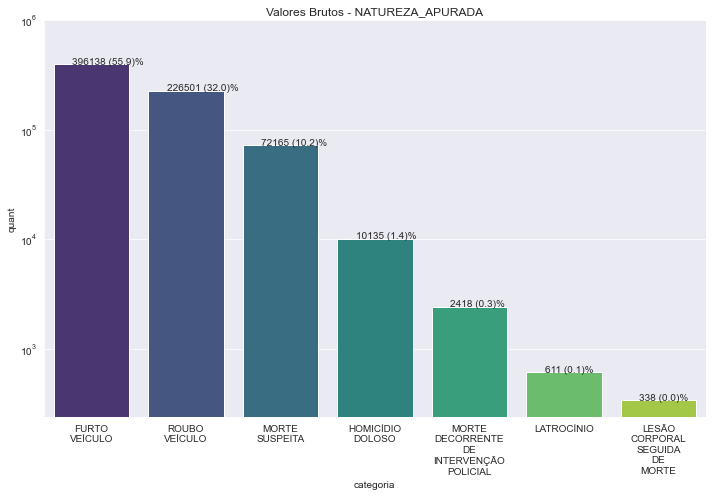

CIDADE


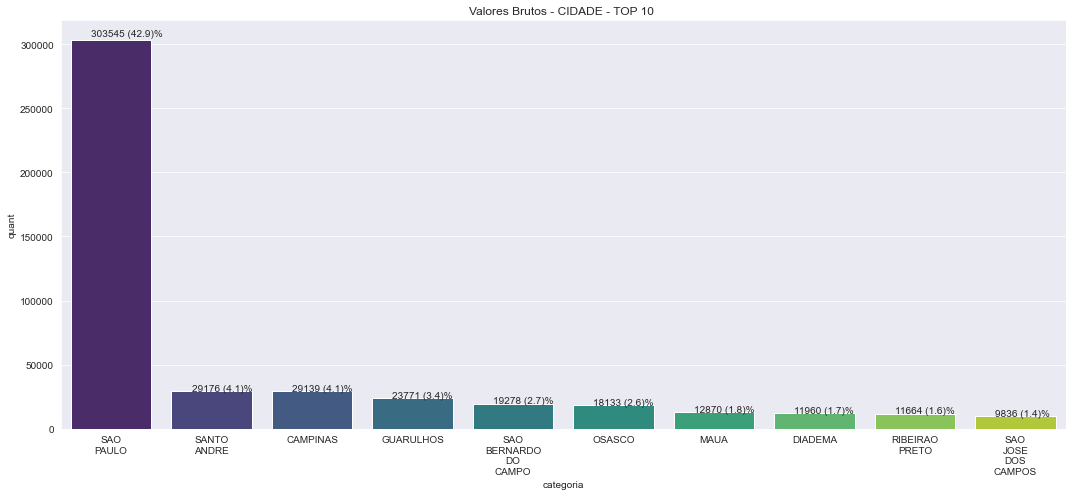

DESCRICAOLOCAL


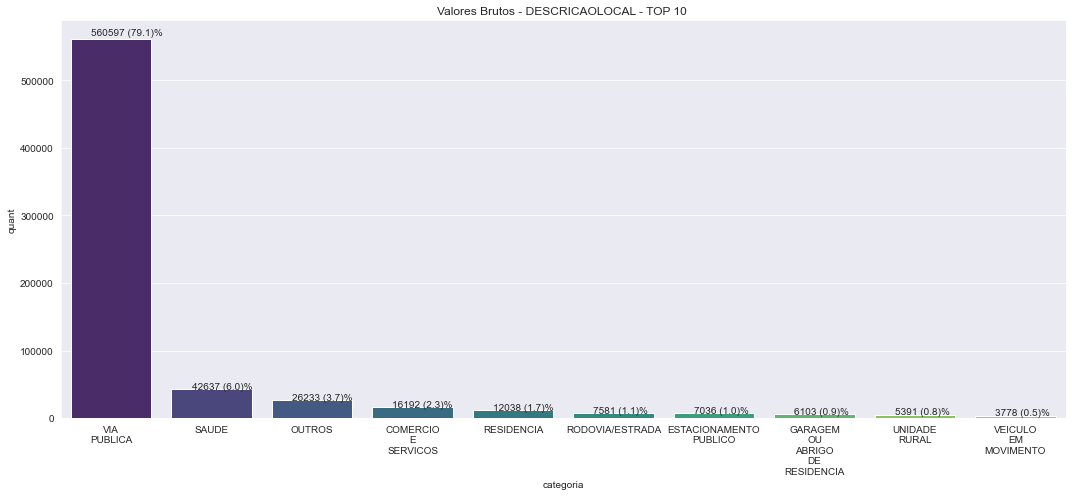

HORA_PERIODO


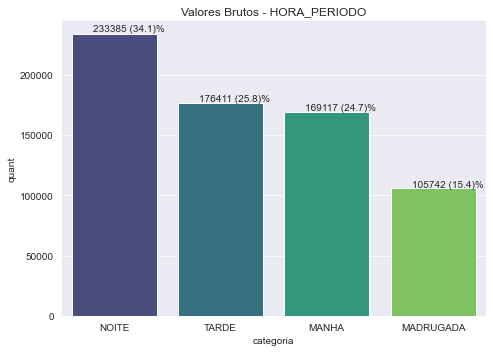

In [12]:
PLOT_TOP_10 = True # False: Plot last 10

for col in ['NATUREZA_APURADA','CIDADE','DESCRICAOLOCAL','HORA_PERIODO']:
    
    print(col)
    
    df_plot_bar = df_crimes_all[col].value_counts().reset_index().rename({'index':'categoria',col:'quant'},axis=1
                                                                                   ).join(df_crimes_all[col].value_counts(normalize=True),on='categoria'
                                                                                         ).rename({col:'porcent'},axis=1)
    
    figheight = 7
    
    top10 = ''
    if len(df_plot_bar['categoria']) > 10:
        figwidth = 15
        
        if PLOT_TOP_10:
            df_plot_bar = df_plot_bar.head(10)
            top10 = ' - TOP 10 '
        else:
            df_plot_bar = df_plot_bar.loc[df_plot_bar['quant']>100].tail(10)
            top10 = ' - LAST 10 '
            
    elif len(df_plot_bar['categoria']) > 5:
        figwidth = 10
    else:
        figwidth = 7
        figheight = 5
    
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(figwidth, figheight))

    
    sns.barplot(data=df_plot_bar,x='categoria',y='quant',ax=ax1,palette='viridis')
    ax1.set_title(f'Valores Brutos - {col}{top10}')
    
    if df_plot_bar['quant'].max()/df_plot_bar['quant'].min() > 1e3:
        
        ax1.set_yscale('log')
        
        max_val_log = [i for i in map(lambda x: x if x > df_plot_bar['quant'].max() else None,[1e4,1e5,1e6,1e7]) if i is not None][0]
        ax1.set_ylim(0,max_val_log)
    
    if df_plot_bar['categoria'].apply(len).max() > 15:
        ax1.set_xticklabels([i.get_text().replace(' ','\n') for i in ax1.get_xticklabels()])
    
    for ind,value in enumerate(df_plot_bar['quant']):
        
        percent = round(df_plot_bar['porcent'].iloc[ind]*100,1)

        ax1.text(x = ind-0.2,
                 y = value + 0.01*value,
                 s = str(value) + f' ({percent})%')

    plt.tight_layout()
    
    plt.savefig(EXPORT_CHARTS_TCC + f'grafico_barras_{col}.png')
    
    plt.show()

## Taxa de eventos por cidade

In [12]:
homicidio_rate = df_crimes['CIDADE'].value_counts().reset_index().rename({'index':'Cidade','CIDADE':'Eventos_Criminosos'},axis=1)
homicidio_rate = homicidio_rate.join(populacao_SP.set_index('Cidade')['Populacao'],on='Cidade')
homicidio_rate_valid = homicidio_rate.dropna().reset_index(drop=True)
homicidio_rate_valid['Eventos_Criminosos_1000_hab'] = homicidio_rate_valid['Eventos_Criminosos']*1000 / homicidio_rate_valid['Populacao']
homicidio_rate_valid_geo = homicidio_rate_valid.join(municipios_geo.set_index('nome')[['latitude','longitude']],on='Cidade').dropna().reset_index(drop=True)

homicidio_rate_valid_geo

,Cidade,Eventos_Criminosos,Populacao,Eventos_Criminosos_1000_hab,latitude,longitude
0,SAO PAULO,303545,12396372,24.486600,-23.5329,-46.6395
1,SANTO ANDRE,29176,723889,40.304522,-23.6737,-46.5432
2,CAMPINAS,29139,1223237,23.821222,-22.9053,-47.0659
3,GUARULHOS,23771,1404694,16.922547,-23.4538,-46.5333
4,SAO BERNARDO DO CAMPO,19278,849874,22.683362,-23.6914,-46.5646
5,OSASCO,18133,701428,25.851549,-23.5324,-46.7916
6,MAUA,12870,481725,26.716488,-23.6677,-46.4613
7,DIADEMA,11960,429550,27.843092,-23.6813,-46.6205
8,RIBEIRAO PRETO,11664,720116,16.197390,-21.1699,-47.8099
9,SAO JOSE DOS CAMPOS,9836,737310,13.340386,-23.1896,-45.8841


# Análise Time Series

## Pivot Table

In [13]:
print('Representatividade das 10 cidades selecionadas: ', round(df_crimes['CIDADE'].value_counts(normalize=True)[:10].sum()*100,1))

try:
    print('Cidades Selecionadas:\n','\n'.join(cidades_selecionadas),'\n')
except:
    cidades_selecionadas = round(df_crimes['CIDADE'].value_counts()/10000)>=1
    cidades_selecionadas = list(cidades_selecionadas[cidades_selecionadas].index)[:10]

print("Média mínima de eventos por dia com base no critério de seleção de cidades:", 10000/1826)

time_pivot_table = df_crimes.loc[df_crimes['CIDADE'].isin(cidades_selecionadas),['CIDADE','DATAOCORRENCIA','NATUREZA_APURADA']].pivot_table(index='CIDADE',columns='DATAOCORRENCIA',aggfunc='count')#.fillna(0)
time_pivot_table[time_pivot_table.columns[:10]].style.background_gradient(cmap='coolwarm',axis=0)

Representatividade das 10 cidades selecionadas:  100.0
Cidades Selecionadas:
 SAO PAULO
SANTO ANDRE
CAMPINAS
GUARULHOS
SAO BERNARDO DO CAMPO
OSASCO
MAUA
DIADEMA
RIBEIRAO PRETO
SAO JOSE DOS CAMPOS 

Média mínima de eventos por dia com base no critério de seleção de cidades: 5.47645125958379


## Time Series Anuais - TOP 10 Cidades

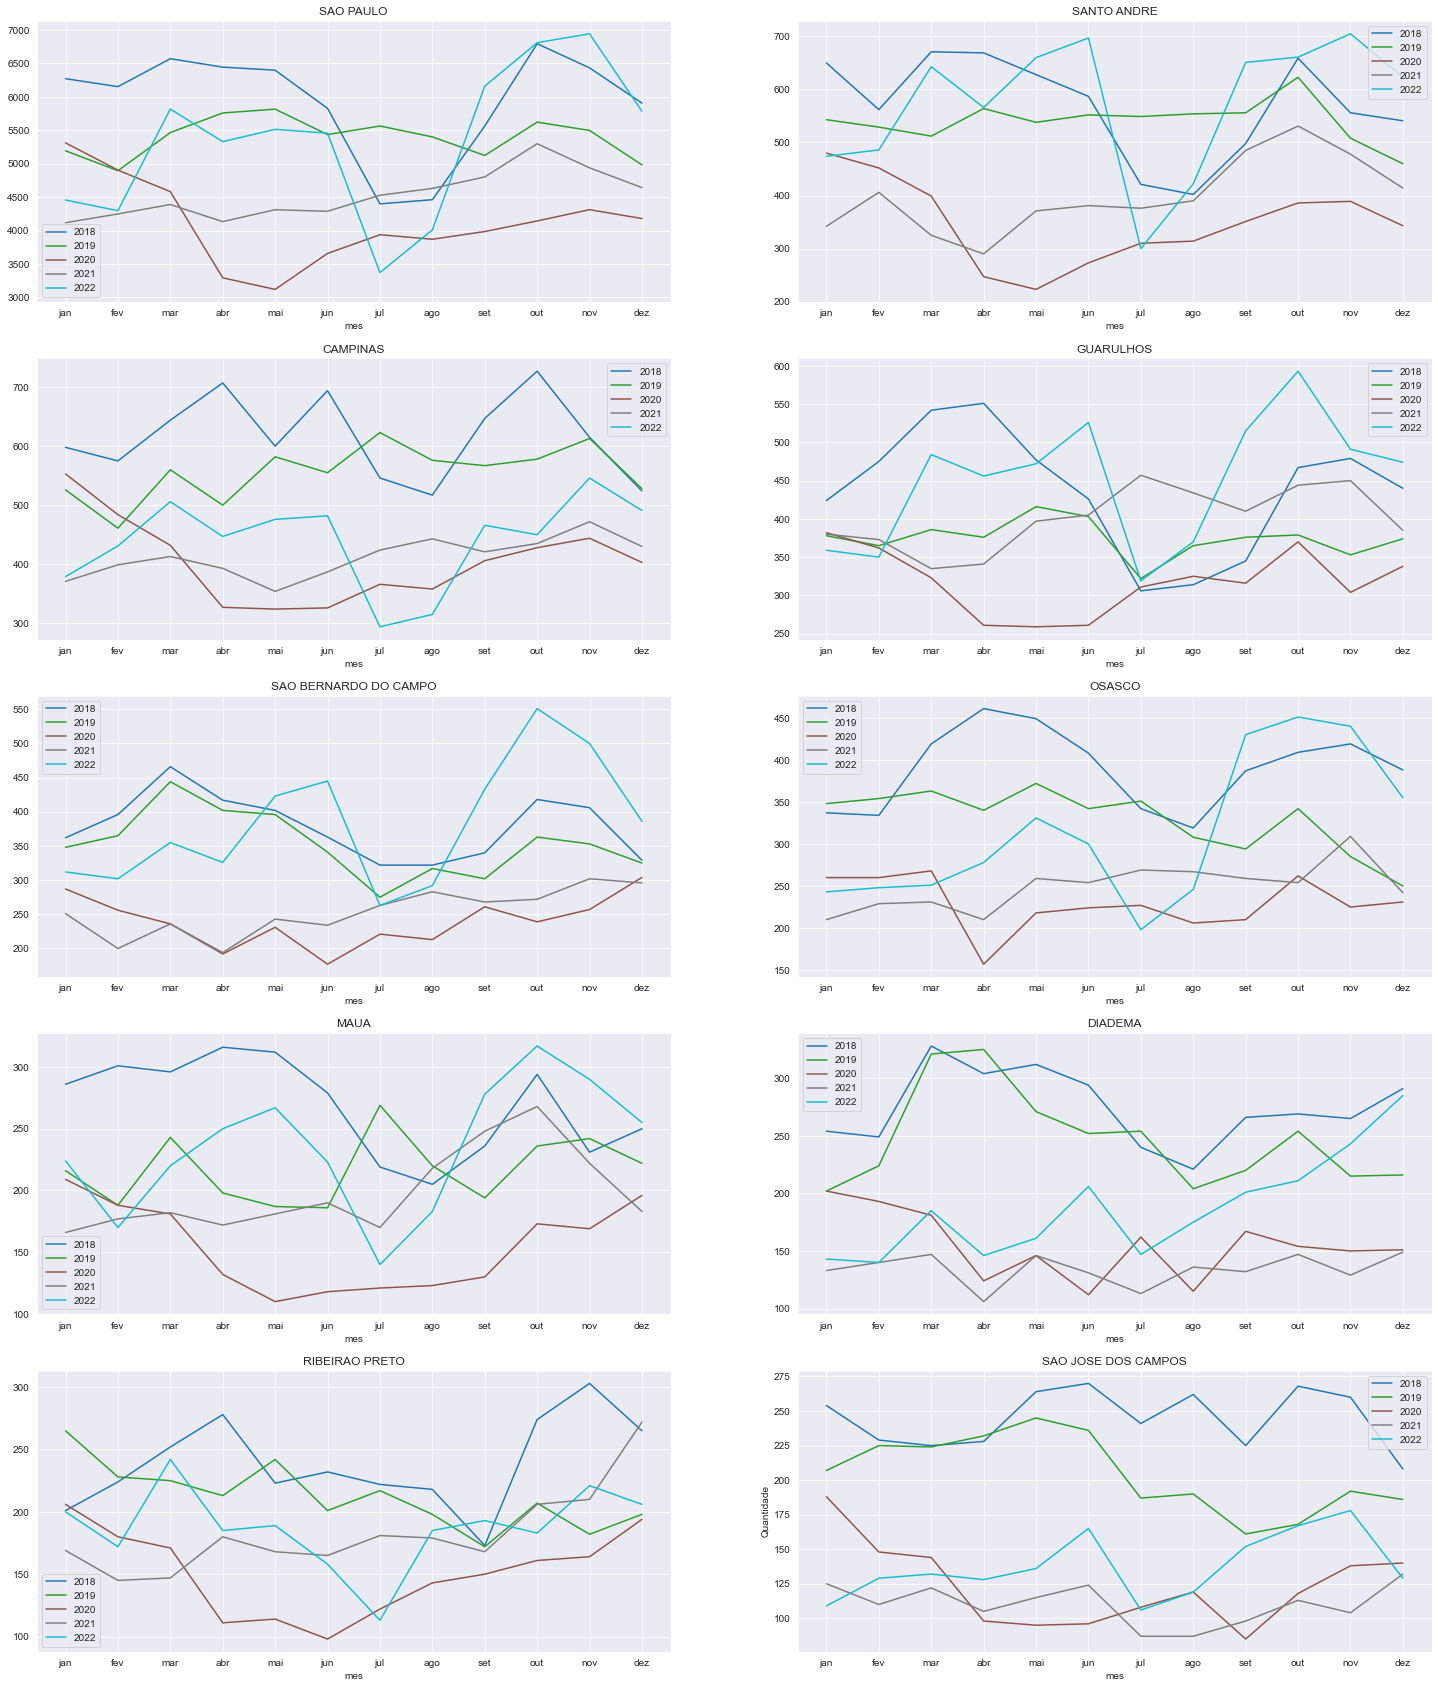

In [14]:
dict_piv = {}

time_series = time_pivot_table.melt(ignore_index=False).reset_index()

time_series['doy'] = time_series['DATAOCORRENCIA'].apply(lambda x: x.timetuple().tm_yday)

time_series['year'] = time_series['DATAOCORRENCIA'].apply(lambda x: x.year)

time_series['mes'] = time_series['DATAOCORRENCIA'].apply(lambda x: x.month)

fig,axs = plt.subplots(nrows=5,ncols=2)

for i,ax in enumerate(axs.reshape(-1)): 
        
    cidade = list(time_pivot_table.reset_index().groupby('CIDADE').sum().sum(axis=1).sort_values(ascending=False).index)[i]
        
    df_plot = time_series.loc[time_series['CIDADE']==cidade]
    
    piv = pd.pivot_table(df_plot, index=['mes'],columns=['year'], values=['value'],aggfunc='sum')
    
    piv.plot(colormap='tab10',ax=ax)
    ax.set_xticks([i for i in range(1,13)],'jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez'.split(','))
    plt.ylabel('Quantidade')
    legend = [2018,2019,2020,2021,2022]

    ax.legend(legend)
    # ax.legend()
    
    dict_piv[cidade] = piv.mean()
    
    ax.set_title(cidade)
    
fig.figure.set_figheight(30)
fig.figure.set_figwidth(25)

plt.savefig(EXPORT_CHARTS_TCC + 'TOP10Cidades_TimeSeries.png')

plt.show()

### Correlação entre curvas anuais - TOP 10 Cidades

In [15]:
for cidade in time_series['CIDADE'].unique():
    print(bold,cidade)
    
    display(
        time_series.loc[
            time_series['CIDADE']==cidade]
        .pivot_table(columns='year',index='mes',values='value',aggfunc='sum'
                    ).dropna().corr().style.background_gradient(
            cmap='coolwarm_r',vmin=-1,vmax=1).set_precision(2)
           )

 CAMPINAS


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,-0.07,-0.13,-0.17,0.45
2019,-0.07,1.00,-0.29,0.42,-0.10
2020,-0.13,-0.29,1.00,0.08,0.02
2021,-0.17,0.42,0.08,1.00,0.06
2022,0.45,-0.10,0.02,0.06,1.00


 DIADEMA


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.74,-0.08,0.21,0.19
2019,0.74,1.00,-0.17,-0.23,-0.27
2020,-0.08,-0.17,1.00,0.26,-0.25
2021,0.21,-0.23,0.26,1.00,0.42
2022,0.19,-0.27,-0.25,0.42,1.00


 GUARULHOS


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.46,-0.15,-0.66,0.39
2019,0.46,1.00,-0.32,-0.46,0.54
2020,-0.15,-0.32,1.00,0.08,-0.22
2021,-0.66,-0.46,0.08,1.00,0.02
2022,0.39,0.54,-0.22,0.02,1.00


 MAUA


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,-0.47,0.20,-0.29,0.25
2019,-0.47,1.00,0.21,0.08,-0.16
2020,0.20,0.21,1.00,-0.09,0.12
2021,-0.29,0.08,-0.09,1.00,0.61
2022,0.25,-0.16,0.12,0.61,1.00


 OSASCO


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.10,-0.36,0.01,0.45
2019,0.10,1.00,0.23,-0.37,-0.49
2020,-0.36,0.23,1.00,-0.06,-0.02
2021,0.01,-0.37,-0.06,1.00,0.47
2022,0.45,-0.49,-0.02,0.47,1.00


 RIBEIRAO PRETO


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,-0.20,0.01,0.50,0.31
2019,-0.20,1.00,0.21,-0.37,-0.03
2020,0.01,0.21,1.00,0.27,0.52
2021,0.50,-0.37,0.27,1.00,0.12
2022,0.31,-0.03,0.52,0.12,1.00


 SANTO ANDRE


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.13,0.13,-0.22,0.55
2019,0.13,1.00,-0.11,0.25,-0.08
2020,0.13,-0.11,1.00,0.25,-0.13
2021,-0.22,0.25,0.25,1.00,0.34
2022,0.55,-0.08,-0.13,0.34,1.00


 SAO BERNARDO DO CAMPO


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.92,-0.16,-0.43,0.33
2019,0.92,1.00,-0.15,-0.51,0.15
2020,-0.16,-0.15,1.00,0.44,0.05
2021,-0.43,-0.51,0.44,1.00,0.37
2022,0.33,0.15,0.05,0.37,1.00


 SAO JOSE DOS CAMPOS


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.12,-0.11,-0.14,0.36
2019,0.12,1.00,0.01,0.36,-0.15
2020,-0.11,0.01,1.00,0.42,-0.31
2021,-0.14,0.36,0.42,1.00,0.15
2022,0.36,-0.15,-0.31,0.15,1.00


 SAO PAULO


year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.13,0.16,0.02,0.69
2019,0.13,1.00,-0.66,0.06,0.16
2020,0.16,-0.66,1.00,-0.03,-0.12
2021,0.02,0.06,-0.03,1.00,0.57
2022,0.69,0.16,-0.12,0.57,1.00


### Correlação entre cidades para cada ano - TOP 10 Cidades

In [16]:
for year in time_series['year'].unique():
    print(bold,'>>> ',year)
    display(
        time_series.loc[time_series['year']==year].pivot_table(
            columns='CIDADE',index='mes',values='value',aggfunc='sum').corr().style.background_gradient(
            cmap='coolwarm_r',vmin=-1,vmax=1).set_precision(2)
           )

 >>>  2018


CIDADE,CAMPINAS,DIADEMA,GUARULHOS,MAUA,OSASCO,RIBEIRAO PRETO,SANTO ANDRE,SAO BERNARDO DO CAMPO,SAO JOSE DOS CAMPOS,SAO PAULO
CIDADE,,,,,,,,,,
CAMPINAS,1.00,0.48,0.52,0.57,0.65,0.27,0.68,0.60,0.24,0.62
DIADEMA,0.48,1.00,0.75,0.65,0.84,0.33,0.72,0.64,-0.22,0.65
GUARULHOS,0.52,0.75,1.00,0.80,0.70,0.62,0.87,0.88,-0.15,0.89
MAUA,0.57,0.65,0.80,1.00,0.53,0.17,0.89,0.72,-0.02,0.78
OSASCO,0.65,0.84,0.70,0.53,1.00,0.52,0.64,0.62,0.02,0.65
RIBEIRAO PRETO,0.27,0.33,0.62,0.17,0.52,1.00,0.36,0.50,0.04,0.47
SANTO ANDRE,0.68,0.72,0.87,0.89,0.64,0.36,1.00,0.80,0.04,0.93
SAO BERNARDO DO CAMPO,0.60,0.64,0.88,0.72,0.62,0.50,0.80,1.00,0.04,0.81
SAO JOSE DOS CAMPOS,0.24,-0.22,-0.15,-0.02,0.02,0.04,0.04,0.04,1.00,0.01


 >>>  2019


CIDADE,CAMPINAS,DIADEMA,GUARULHOS,MAUA,OSASCO,RIBEIRAO PRETO,SANTO ANDRE,SAO BERNARDO DO CAMPO,SAO JOSE DOS CAMPOS,SAO PAULO
CIDADE,,,,,,,,,,
CAMPINAS,1.00,-0.07,-0.25,0.60,-0.09,-0.32,0.14,-0.33,-0.39,0.51
DIADEMA,-0.07,1.00,0.27,0.03,0.53,0.17,0.17,0.69,0.51,0.62
GUARULHOS,-0.25,0.27,1.00,-0.69,0.26,0.23,0.06,0.57,0.52,0.18
MAUA,0.60,0.03,-0.69,1.00,-0.10,-0.07,-0.06,-0.20,-0.47,0.18
OSASCO,-0.09,0.53,0.26,-0.10,1.00,0.70,0.47,0.46,0.60,0.45
RIBEIRAO PRETO,-0.32,0.17,0.23,-0.07,0.70,1.00,0.03,0.39,0.55,0.10
SANTO ANDRE,0.14,0.17,0.06,-0.06,0.47,0.03,1.00,-0.04,-0.17,0.46
SAO BERNARDO DO CAMPO,-0.33,0.69,0.57,-0.20,0.46,0.39,-0.04,1.00,0.63,0.34
SAO JOSE DOS CAMPOS,-0.39,0.51,0.52,-0.47,0.60,0.55,-0.17,0.63,1.00,0.29


 >>>  2020


CIDADE,CAMPINAS,DIADEMA,GUARULHOS,MAUA,OSASCO,RIBEIRAO PRETO,SANTO ANDRE,SAO BERNARDO DO CAMPO,SAO JOSE DOS CAMPOS,SAO PAULO
CIDADE,,,,,,,,,,
CAMPINAS,1.00,0.85,0.85,0.86,0.70,0.89,0.97,0.72,0.87,0.96
DIADEMA,0.85,1.00,0.69,0.69,0.69,0.73,0.80,0.68,0.66,0.80
GUARULHOS,0.85,0.69,1.00,0.78,0.71,0.86,0.88,0.68,0.73,0.85
MAUA,0.86,0.69,0.78,1.00,0.66,0.93,0.85,0.75,0.88,0.85
OSASCO,0.70,0.69,0.71,0.66,1.00,0.64,0.75,0.47,0.64,0.75
RIBEIRAO PRETO,0.89,0.73,0.86,0.93,0.64,1.00,0.87,0.88,0.85,0.86
SANTO ANDRE,0.97,0.80,0.88,0.85,0.75,0.87,1.00,0.64,0.83,0.98
SAO BERNARDO DO CAMPO,0.72,0.68,0.68,0.75,0.47,0.88,0.64,1.00,0.63,0.63
SAO JOSE DOS CAMPOS,0.87,0.66,0.73,0.88,0.64,0.85,0.83,0.63,1.00,0.89


 >>>  2021


CIDADE,CAMPINAS,DIADEMA,GUARULHOS,MAUA,OSASCO,RIBEIRAO PRETO,SANTO ANDRE,SAO BERNARDO DO CAMPO,SAO JOSE DOS CAMPOS,SAO PAULO
CIDADE,,,,,,,,,,
CAMPINAS,1.00,-0.01,0.54,0.56,0.64,0.48,0.58,0.67,-0.41,0.75
DIADEMA,-0.01,1.00,-0.07,0.27,0.03,0.16,0.36,0.30,0.53,0.29
GUARULHOS,0.54,-0.07,1.00,0.53,0.81,0.29,0.67,0.68,-0.53,0.67
MAUA,0.56,0.27,0.53,1.00,0.49,0.20,0.86,0.50,-0.27,0.89
OSASCO,0.64,0.03,0.81,0.49,1.00,0.26,0.60,0.69,-0.45,0.63
RIBEIRAO PRETO,0.48,0.16,0.29,0.20,0.26,1.00,0.36,0.66,0.22,0.48
SANTO ANDRE,0.58,0.36,0.67,0.86,0.60,0.36,1.00,0.60,-0.15,0.89
SAO BERNARDO DO CAMPO,0.67,0.30,0.68,0.50,0.69,0.66,0.60,1.00,-0.12,0.71
SAO JOSE DOS CAMPOS,-0.41,0.53,-0.53,-0.27,-0.45,0.22,-0.15,-0.12,1.00,-0.24


 >>>  2022


CIDADE,CAMPINAS,DIADEMA,GUARULHOS,MAUA,OSASCO,RIBEIRAO PRETO,SANTO ANDRE,SAO BERNARDO DO CAMPO,SAO JOSE DOS CAMPOS,SAO PAULO
CIDADE,,,,,,,,,,
CAMPINAS,1.00,0.57,0.73,0.70,0.63,0.66,0.93,0.69,0.72,0.86
DIADEMA,0.57,1.00,0.60,0.54,0.67,0.39,0.59,0.61,0.56,0.66
GUARULHOS,0.73,0.60,1.00,0.86,0.80,0.39,0.89,0.90,0.82,0.91
MAUA,0.70,0.54,0.86,1.00,0.90,0.53,0.82,0.87,0.72,0.93
OSASCO,0.63,0.67,0.80,0.90,1.00,0.36,0.74,0.91,0.83,0.89
RIBEIRAO PRETO,0.66,0.39,0.39,0.53,0.36,1.00,0.59,0.31,0.27,0.61
SANTO ANDRE,0.93,0.59,0.89,0.82,0.74,0.59,1.00,0.84,0.82,0.92
SAO BERNARDO DO CAMPO,0.69,0.61,0.90,0.87,0.91,0.31,0.84,1.00,0.92,0.90
SAO JOSE DOS CAMPOS,0.72,0.56,0.82,0.72,0.83,0.27,0.82,0.92,1.00,0.85


## Time Series Anuais - TOP 10 Cidades Agrupadas

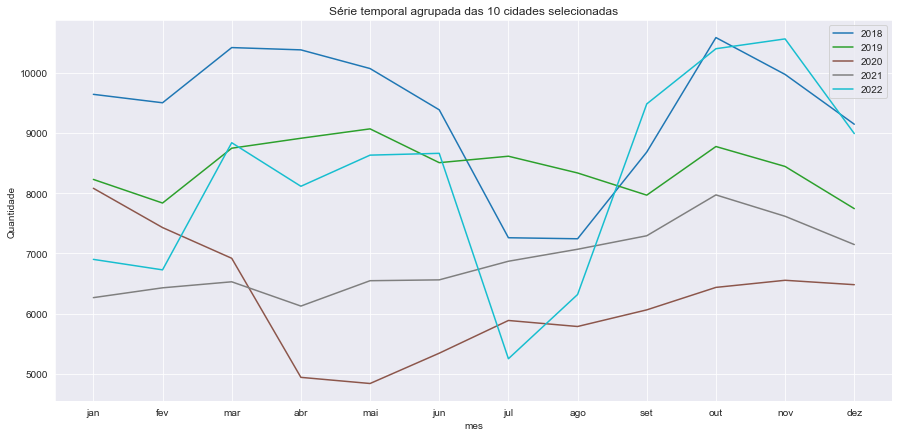

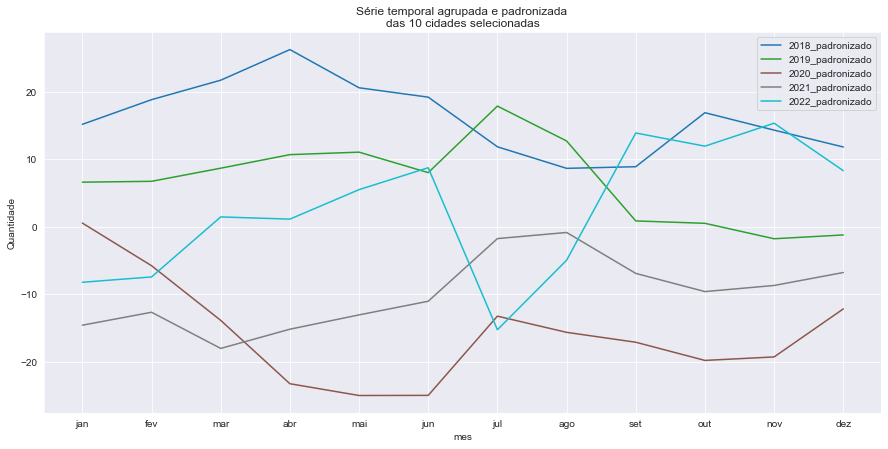

In [17]:
df_plot_grouped = time_series.groupby('DATAOCORRENCIA').agg({'value':'sum','year':'min','mes':'min'})
piv = pd.pivot_table(df_plot_grouped, index=['mes'],columns=['year'], values=['value'],aggfunc='sum')
piv.plot(figsize=(15,7),colormap='tab10')
plt.xticks([i for i in range(1,13)],'jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez'.split(','))
plt.ylabel('Quantidade')
legend = [2018,2019,2020,2021,2022]

plt.legend(legend)
plt.title('Série temporal agrupada das 10 cidades selecionadas')
plt.savefig(EXPORT_CHARTS_TCC + 'TOP10Cidades_Agrupadas_TimeSeries.png')
plt.show()

########################################################################################################################

groups = time_series.groupby(['CIDADE','mes'])
mean, std = groups.transform("mean"), groups.transform("std")
normalized = (time_series['value'] - mean['value']) / std['value']
normalized = normalized.to_frame().join(time_series[['CIDADE','DATAOCORRENCIA','year','mes']])

df_plot_grouped_normalized = normalized.groupby('DATAOCORRENCIA').agg({'value':'mean','year':'min','mes':'min'})
piv = pd.pivot_table(df_plot_grouped_normalized, index=['mes'],columns=['year'], values=['value'],aggfunc='sum')
piv.plot(figsize=(15,7),colormap='tab10')
plt.xticks([i for i in range(1,13)],'jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez'.split(','))
plt.ylabel('Quantidade')
legend = ['2018_padronizado','2019_padronizado','2020_padronizado','2021_padronizado','2022_padronizado']

plt.legend(legend)
plt.title('Série temporal agrupada e padronizada \ndas 10 cidades selecionadas')
plt.savefig(EXPORT_CHARTS_TCC + 'TOP10Cidades_Agrupadas_Padronizadas_TimeSeries.png')
plt.show()

## Time Series Completa para cada Cidade - TOP10 

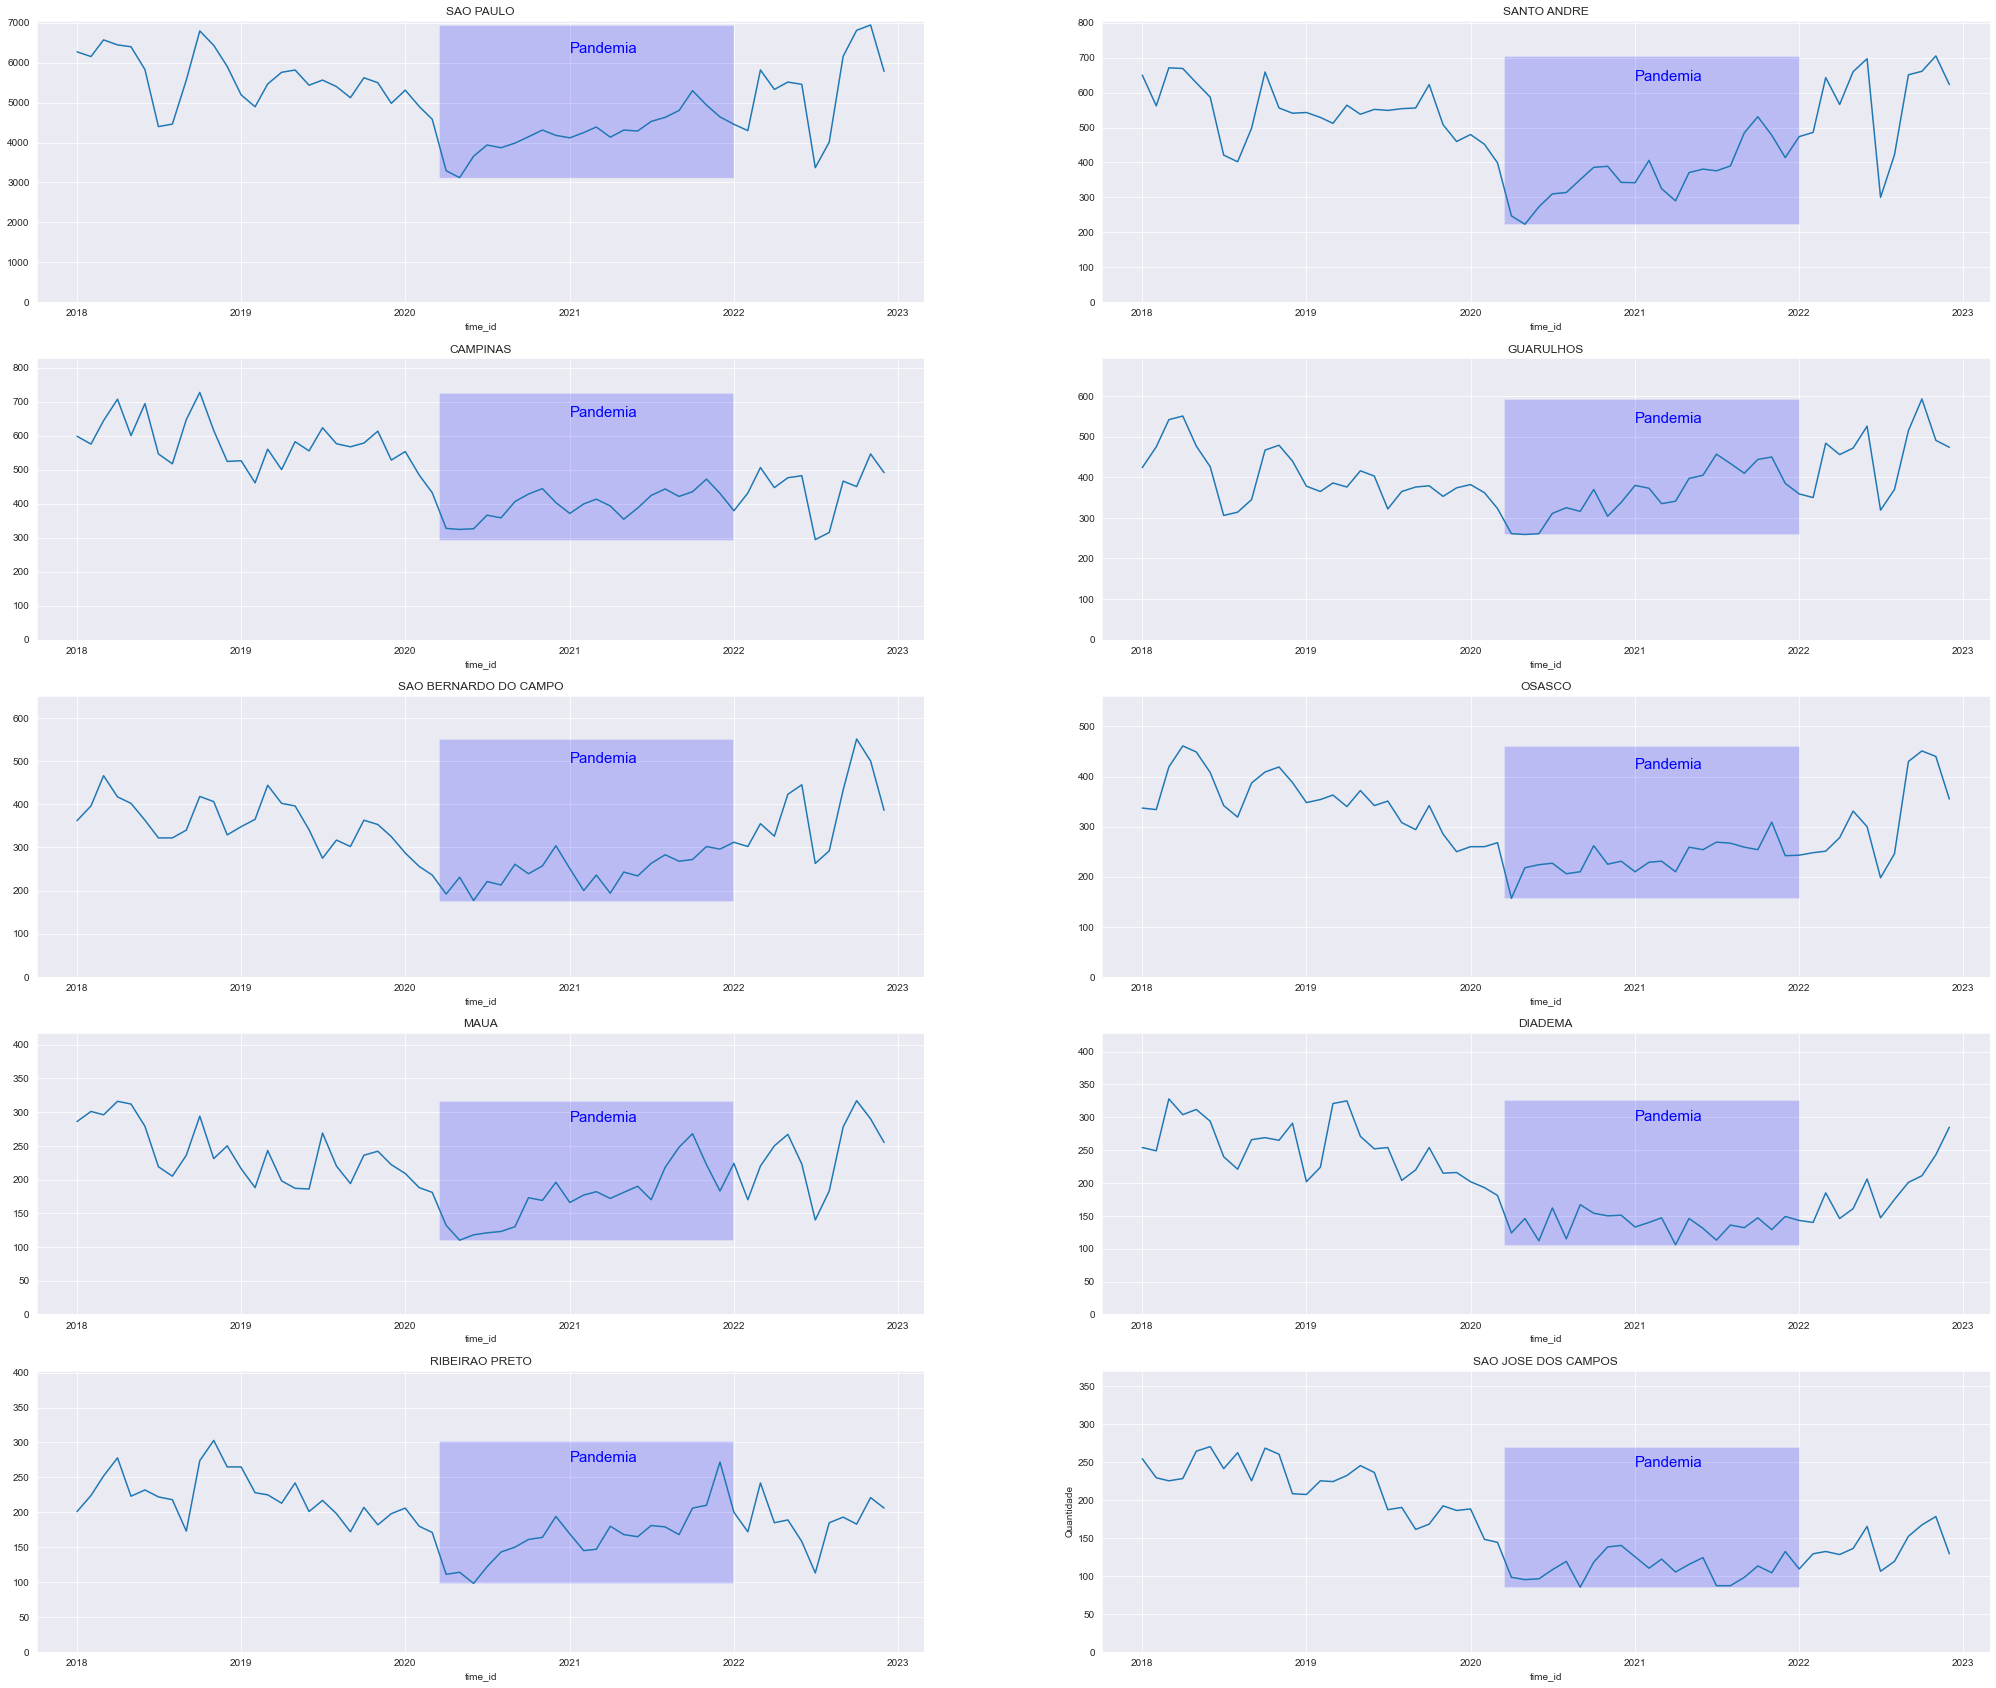

In [20]:
fig,axs = plt.subplots(nrows=5,ncols=2)

for i,ax in enumerate(axs.reshape(-1)): 
        
    cidade = list(time_pivot_table.reset_index().groupby('CIDADE').sum().sum(axis=1).sort_values(ascending=False).index)[i]
        
    df_plot = time_series.loc[time_series['CIDADE']==cidade]
    df_plot['time_id'] = df_plot[['year','mes']].apply(lambda row: datetime.date(row['year'],row['mes'],1),axis=1)
    df_plot = df_plot.groupby('time_id')['value'].sum()
    
    df_plot.plot(colormap='tab10',ax=ax)
    plt.ylabel('Quantidade')
    ax.set_ylim((0,df_plot.max()+100))
    ax.set_title(cidade)
    ax.fill_betweenx(range(int(df_plot.min()),int(df_plot.max())),datetime.date(2020,3,16), datetime.date(2021,12,31), alpha=0.2,facecolor='blue')
    ax.text(x=datetime.date(2021,1,1),y=df_plot.max()-df_plot.max()*0.1,s='Pandemia',c='blue',size=15)
    
fig.figure.set_figheight(30)
fig.figure.set_figwidth(35)

plt.savefig(EXPORT_CHARTS_TCC + 'TOP10Cidades_TimeSeries_continuo.png')

plt.show()

### Correlação entre curvas anuais - TOP 10 Cidades Agrupadas

In [20]:
df_plot_grouped.reset_index().pivot_table(
    columns='year',index='mes',values='value',aggfunc='sum').dropna().corr().style.background_gradient(
    cmap='coolwarm_r',vmin=-1,vmax=1).set_precision(2)

year,2018,2019,2020,2021,2022
year,,,,,
2018,1.00,0.35,0.11,-0.08,0.67
2019,0.35,1.00,-0.55,-0.12,0.12
2020,0.11,-0.55,1.00,0.03,-0.09
2021,-0.08,-0.12,0.03,1.00,0.55
2022,0.67,0.12,-0.09,0.55,1.00


## Time Series Completa para Todas as Cidades - TOP10 

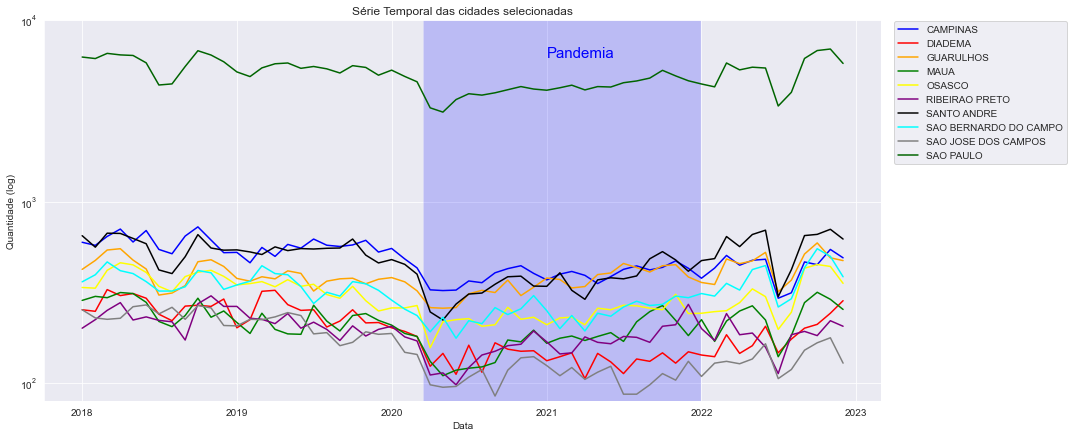

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=1)
colors_list = ['blue','red','orange','green','yellow','purple','black','cyan','gray','darkgreen']
legend_list = []
for i,cidade in enumerate(time_pivot_table.index): 
                
    df_plot = time_series.loc[time_series['CIDADE']==cidade]
    df_plot['time_id'] = df_plot[['year','mes']].apply(lambda row: datetime.date(row['year'],row['mes'],1),axis=1)
    df_plot = df_plot.groupby('time_id')['value'].sum()
    
    df_plot.plot(color=colors_list[i],ax=ax)
    legend_list.append(cidade)

ax.set_ylabel('Quantidade (log)')
ax.set_xlabel('Data')
ax.set_title('Série Temporal das cidades selecionadas')
ax.set_ylim((1e2-20,1e4))

ax.fill_betweenx(range(0,10000),datetime.date(2020,3,16), datetime.date(2021,12,31), alpha=0.2,facecolor='blue')
ax.text(x=datetime.date(2021,1,1),y=6300,s='Pandemia',c='blue',size=15)

ax.set_yscale("log")
ax.legend(legend_list,bbox_to_anchor=(1.01, 1.01))
fig.figure.set_figheight(7)
fig.figure.set_figwidth(15)

plt.savefig(EXPORT_CHARTS_TCC + 'TOP10_Todas_Cidades_TimeSeries_continuo.png')

plt.show()

## Quantidade média de eventos mensais para cada ano e respectivas variações percentuais

In [44]:
def medias_cidades():
    for cidade in dict_piv.keys():
        yield dict_piv[cidade].reset_index(0).drop('level_0',axis=1).rename({0:cidade},axis=1)
        
medias_anuais_cidades = pd.concat(medias_cidades(),axis=1)
medias_anuais_cidades = round(medias_anuais_cidades)

variacoes_medias = round((-(medias_anuais_cidades.shift(1) - medias_anuais_cidades)*100 / medias_anuais_cidades.shift(1)).fillna(0),1
                        ).rename(columns={col:col.lower()+'_var' for col in medias_anuais_cidades.columns})

medias_anuais_cidades_variacoes = pd.concat([medias_anuais_cidades,variacoes_medias],axis=1).sort_index(axis=1,key=lambda col: col.str.lower())

# Multi-Index Columns
colunas_cidades = [i for i in medias_anuais_cidades.columns]
colunas_cidades = colunas_cidades+colunas_cidades
colunas_cidades.sort()
arrays = [np.array(colunas_cidades),np.array(["media\nmensal", "variacao\n(%)"]*10)]
medias_anuais_cidades_variacoes.columns = arrays
# Multi-Index Columns

medias_anuais_cidades_variacoes_style = medias_anuais_cidades_variacoes.style.background_gradient(
    cmap='coolwarm',vmin=-60,vmax=60,subset=[col_mult for col_mult in medias_anuais_cidades_variacoes.columns if '%' in col_mult[1]]).set_precision(2)

medias_anuais_cidades_variacoes_style

## Time Series - Decomposição Temporal

### Dataframe apenas com as cidades selecionadas

In [ ]:
df_crimes_TOP10 = df_crimes.loc[df_crimes['CIDADE'].isin(list(time_pivot_table.index))]
df_crimes_TOP10['Years_Quarters'] = df_crimes_TOP10['DATAOCORRENCIA'].apply(pd.to_datetime).dt.to_period('Q')
df_crimes_TOP10.head()

,arquivo_de_origem,NATUREZA_APURADA,CIDADE,BAIRRO,LOGRADOURO,NUMERO,DESCRICAOLOCAL,LATITUDE,LONGITUDE,DATAOCORRENCIA,HORAOCORRENCIA,PERIDOOCORRENCIA,SEXO,IDADE,HORA_PERIODO,DIA_SEMANA,FERIADO,Descricao_FERIADO,Years_Quarters
0,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SAO PAULO,None,RUA ARATIMBO,98.0,VIA PUBLICA,-23.649501,-46.597479,2018-02-11,02:45:00,EM HORA INCERTA,FEMININO,23.0,MADRUGADA,DOMINGO,False,,2018Q1
1,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SAO PAULO,None,AVENIDA ARQUITETO VILANOVA ARTIGAS,62.0,VIA PUBLICA,-23.614277,-46.501822,2018-02-10,14:00:00,EM HORA INCERTA,FEMININO,31.0,TARDE,SABADO,False,,2018Q1
2,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,CAMPINAS,None,AVENIDA AV. DEP. LUIS EDUARDO MAGALHAES,2605.0,UNIDADE RURAL,-22.936004,-47.187390,2018-03-13,15:00:00,EM HORA INCERTA,FEMININO,24.0,TARDE,TERCA-FEIRA,False,,2018Q1
3,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,SANTO ANDRE,None,RUA BELO HORIZONTE,85.0,VIA PUBLICA,-23.698063,-46.533671,2018-03-27,22:10:00,EM HORA INCERTA,FEMININO,41.0,NOITE,TERCA-FEIRA,False,,2018Q1
4,Feminicidio_2015_2022.parquet,HOMICÍDIO DOLOSO,GUARULHOS,None,RUA TANCREDO ALMEIDA NEVES,0.0,VIA PUBLICA,-23.402639,-46.508294,2018-04-30,15:15:00,EM HORA INCERTA,FEMININO,32.0,TARDE,SEGUNDA-FEIRA,True,EMENDA - DIA DO TRABALHO,2018Q2


### Decomposição Mensal (period=12)

- decomposition_type='multiplicative'

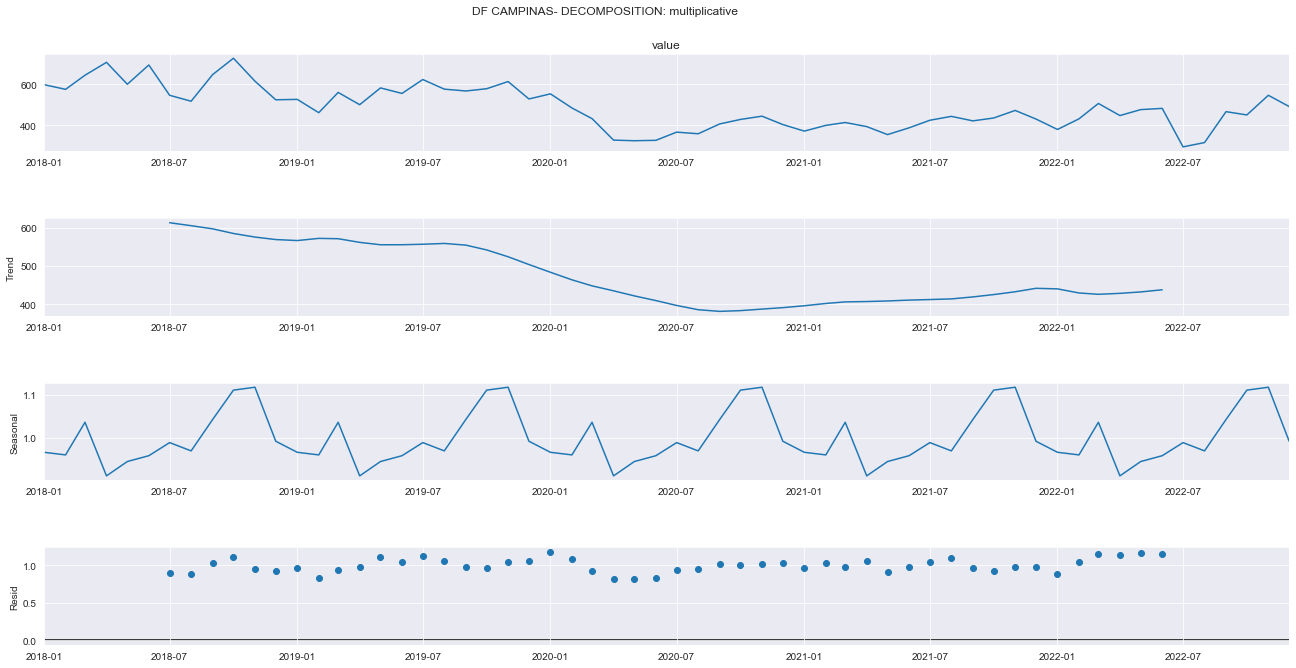

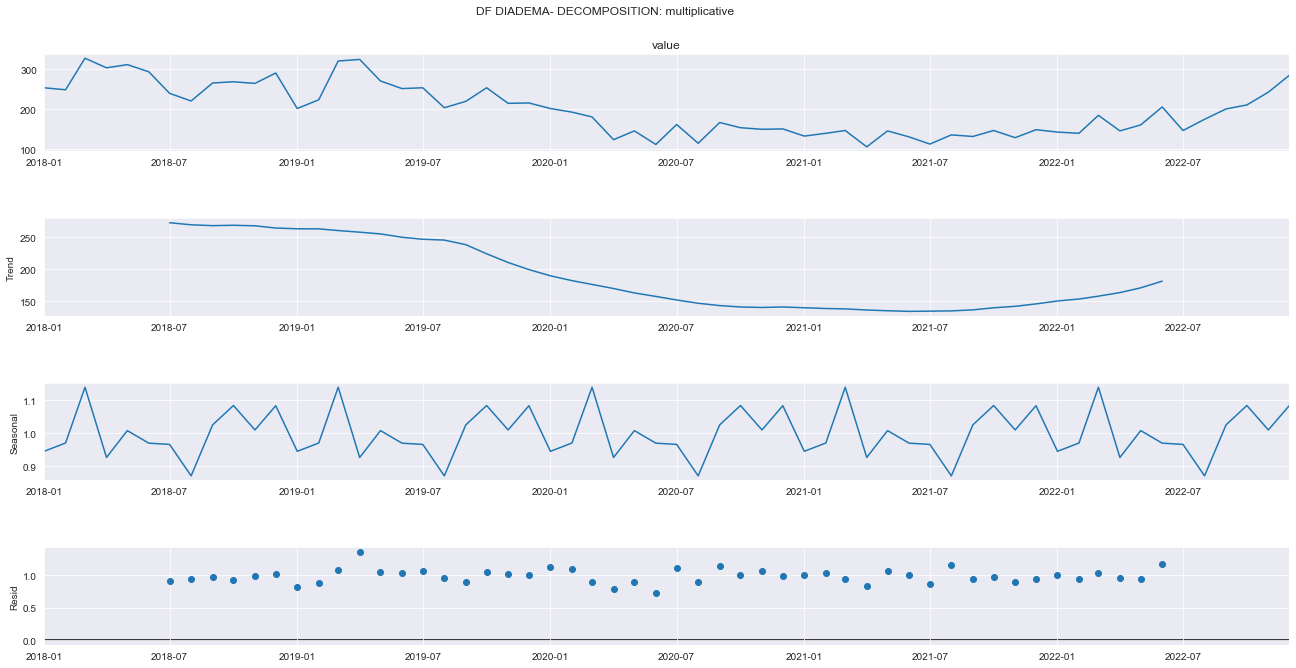

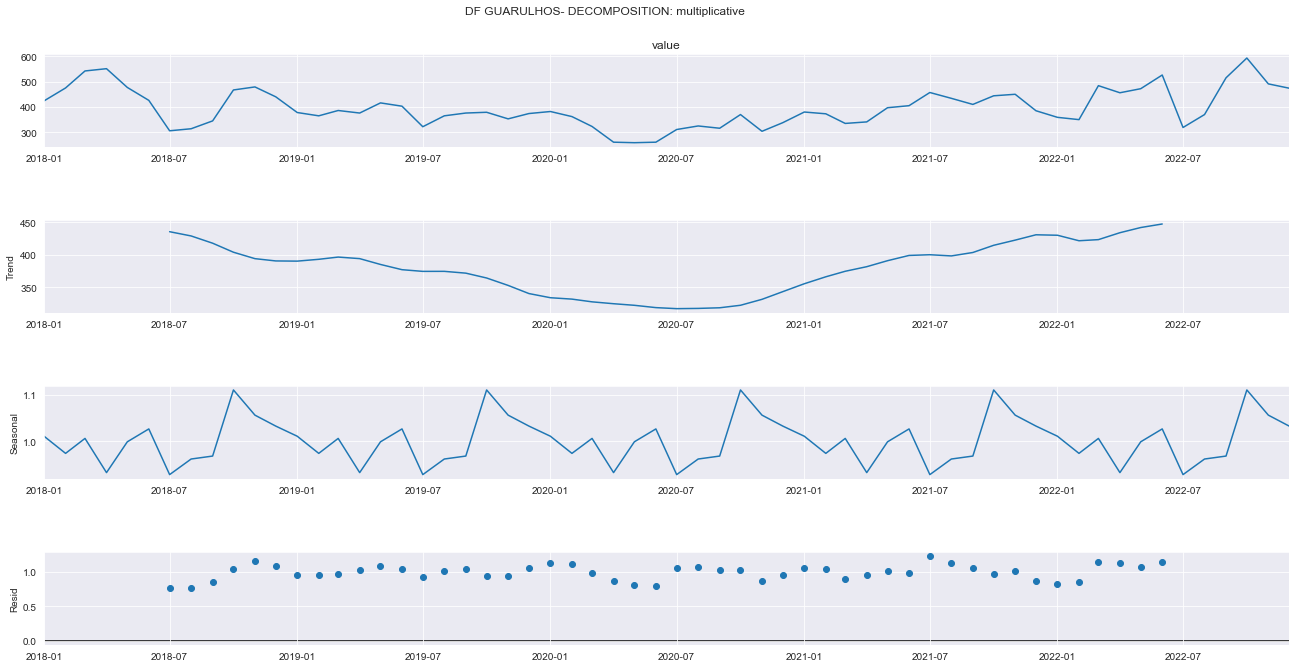

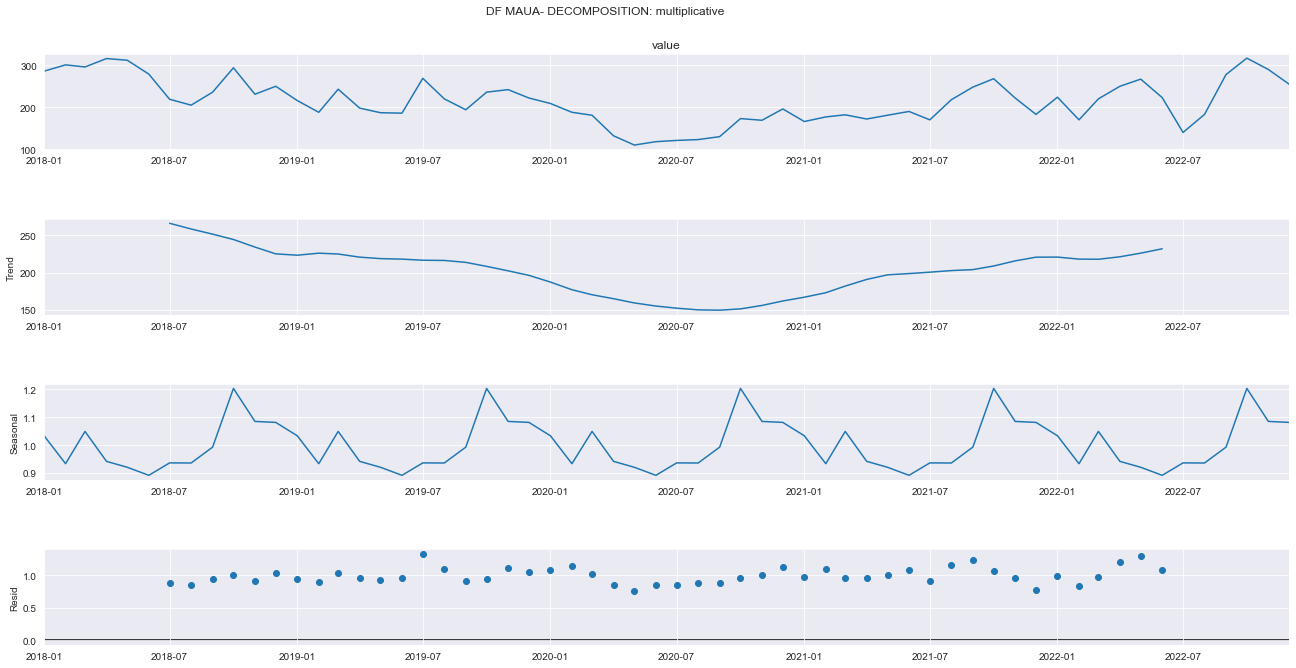

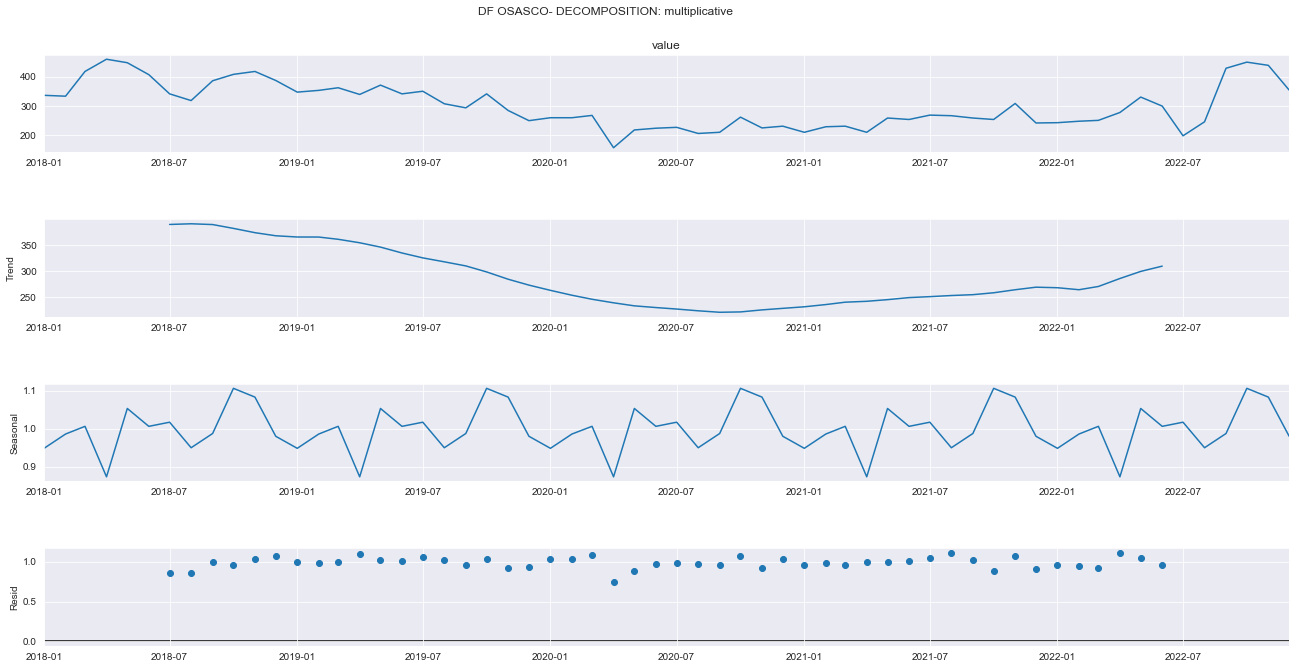

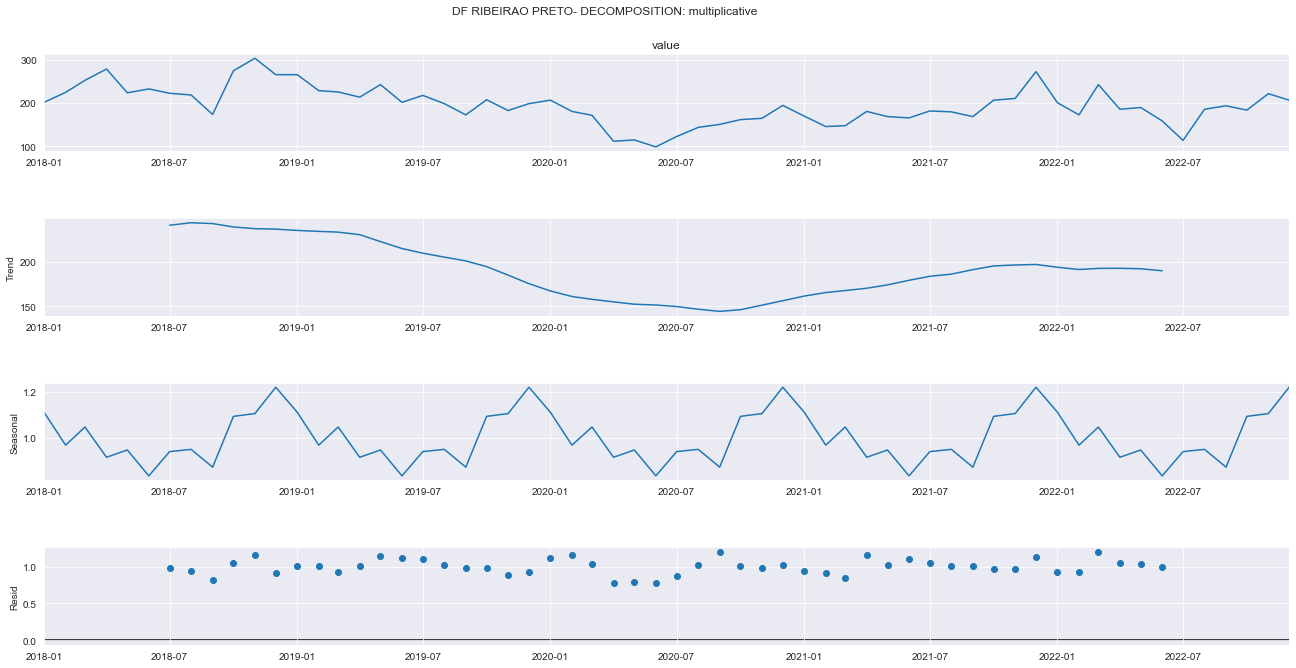

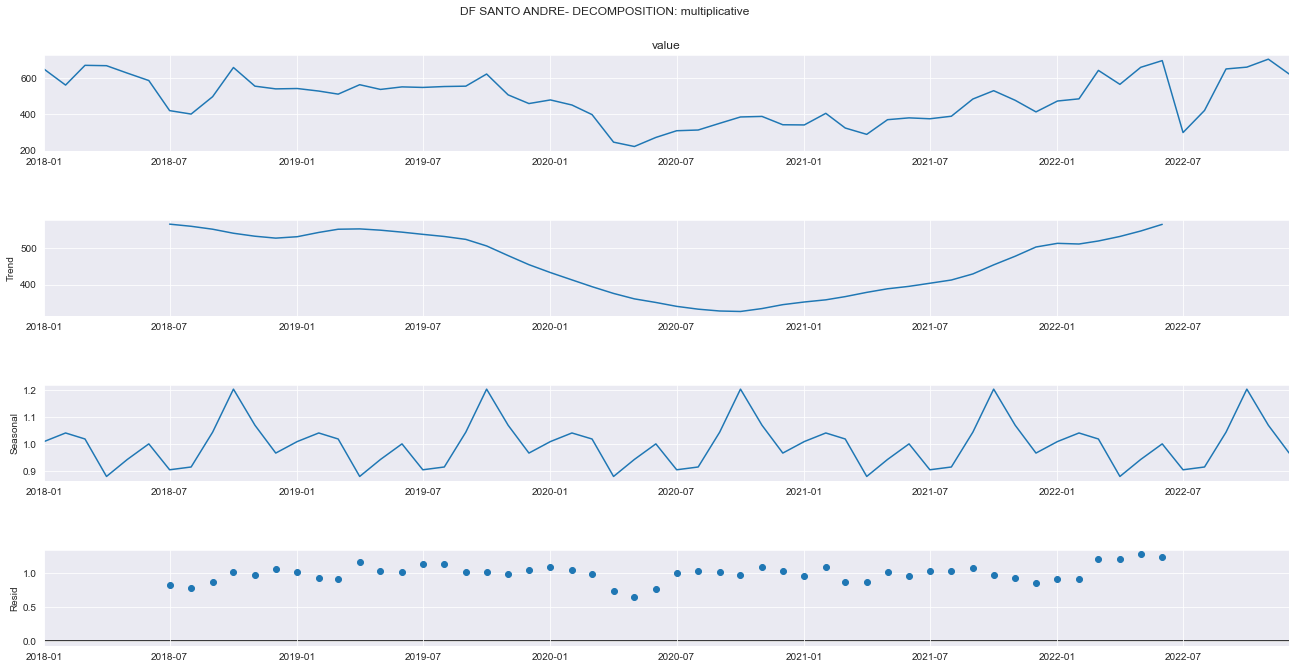

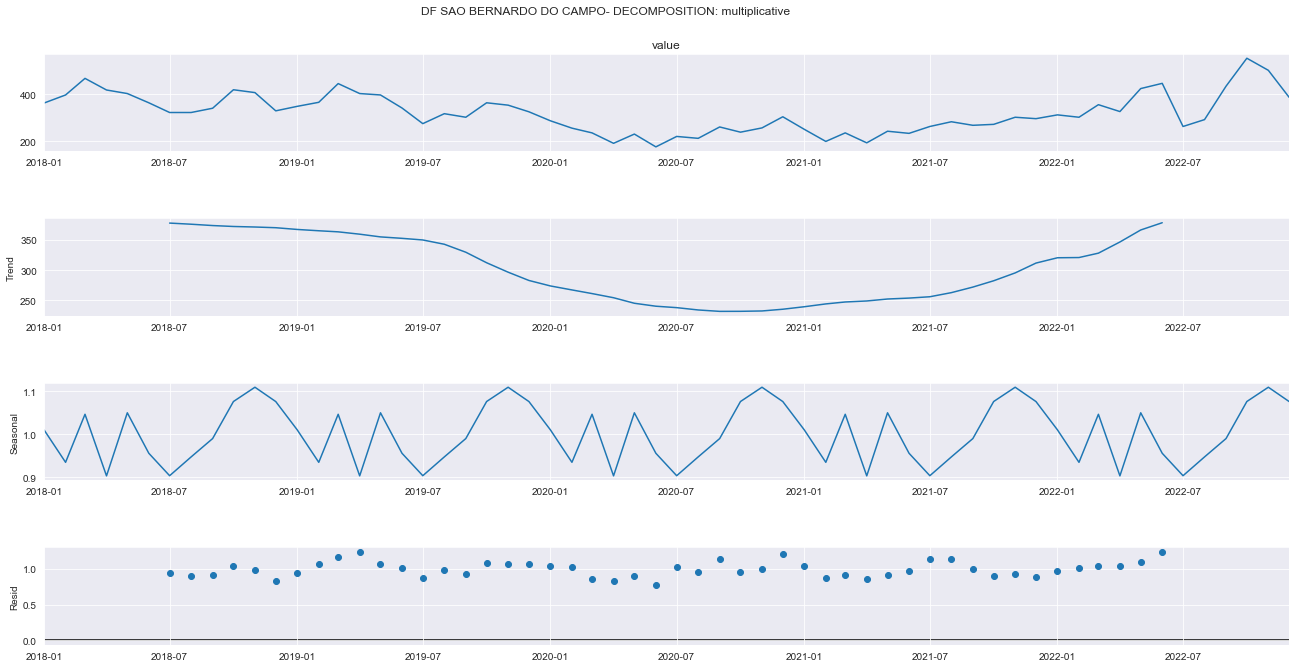

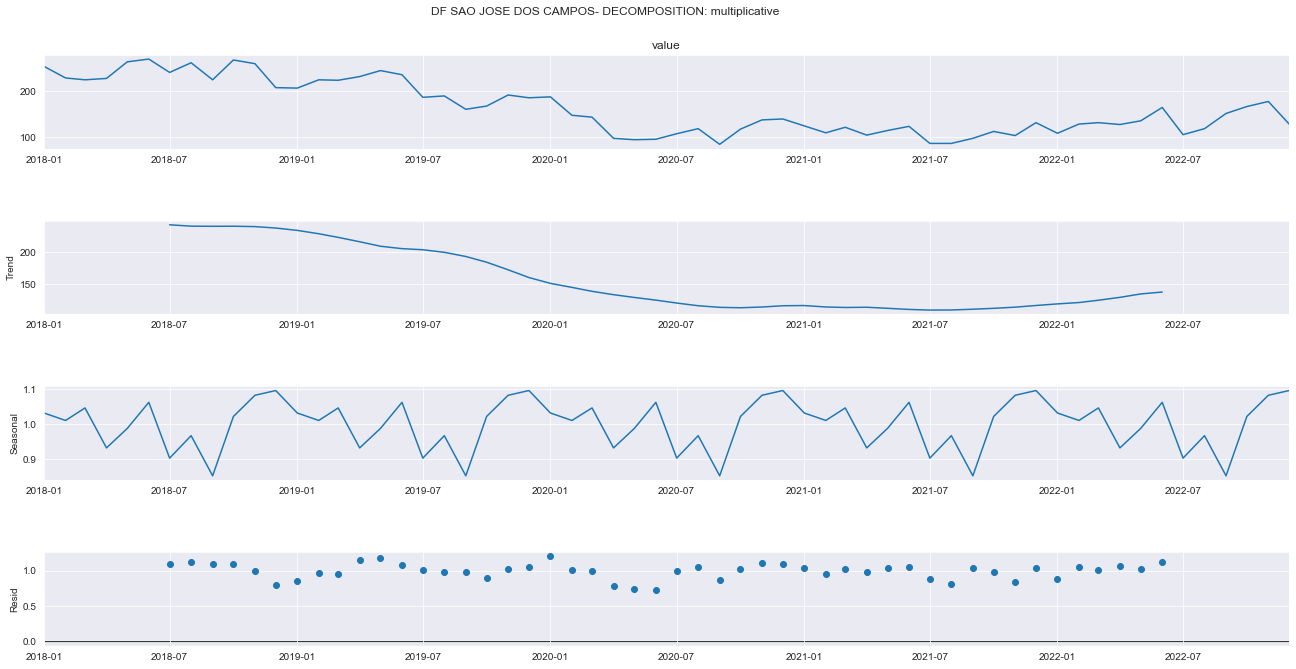

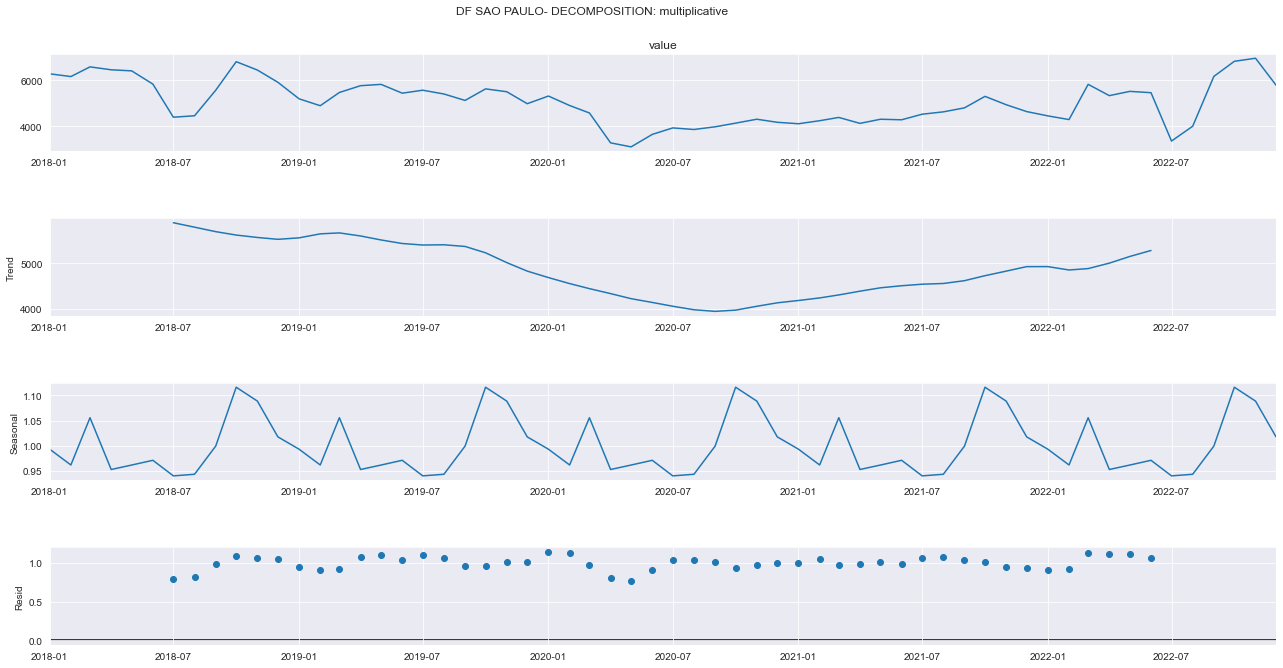

In [ ]:
time_series_to_decomp = time_series.groupby(['year','mes','CIDADE'])['value'].sum().reset_index()
time_series_to_decomp['time_id'] = time_series_to_decomp[['year','mes']].apply(lambda row: datetime.date(row['year'],row['mes'],1),axis=1)

for cidade in time_series_to_decomp['CIDADE'].unique():
    decomposition_ts(time_series_to_decomp.loc[time_series_to_decomp['CIDADE'] == cidade].set_index('time_id')['value'],
                     cidade = cidade,
                     period = 12,
                     decomposition_type='multiplicative')

### Decomposição Mensal (period=12) (additive - Grandes Resíduos)

In [1]:
time_series_to_decomp = time_series.groupby(['year','mes','CIDADE'])['value'].sum().reset_index()
time_series_to_decomp['time_id'] = time_series_to_decomp[['year','mes']].apply(lambda row: datetime.date(row['year'],row['mes'],1),axis=1)

for cidade in time_series_to_decomp['CIDADE'].unique():
    decomposition_ts(time_series_to_decomp.loc[time_series_to_decomp['CIDADE'] == cidade].set_index('time_id')['value'],
                     cidade = cidade,
                     period = 12,
                     decomposition_type='additive')

## Curvas de Autocorrelação

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

### Curva de Autocorrelação (Total ou parcial)
- Filtros de Pandemia ou Cidade

Filtro Cidade


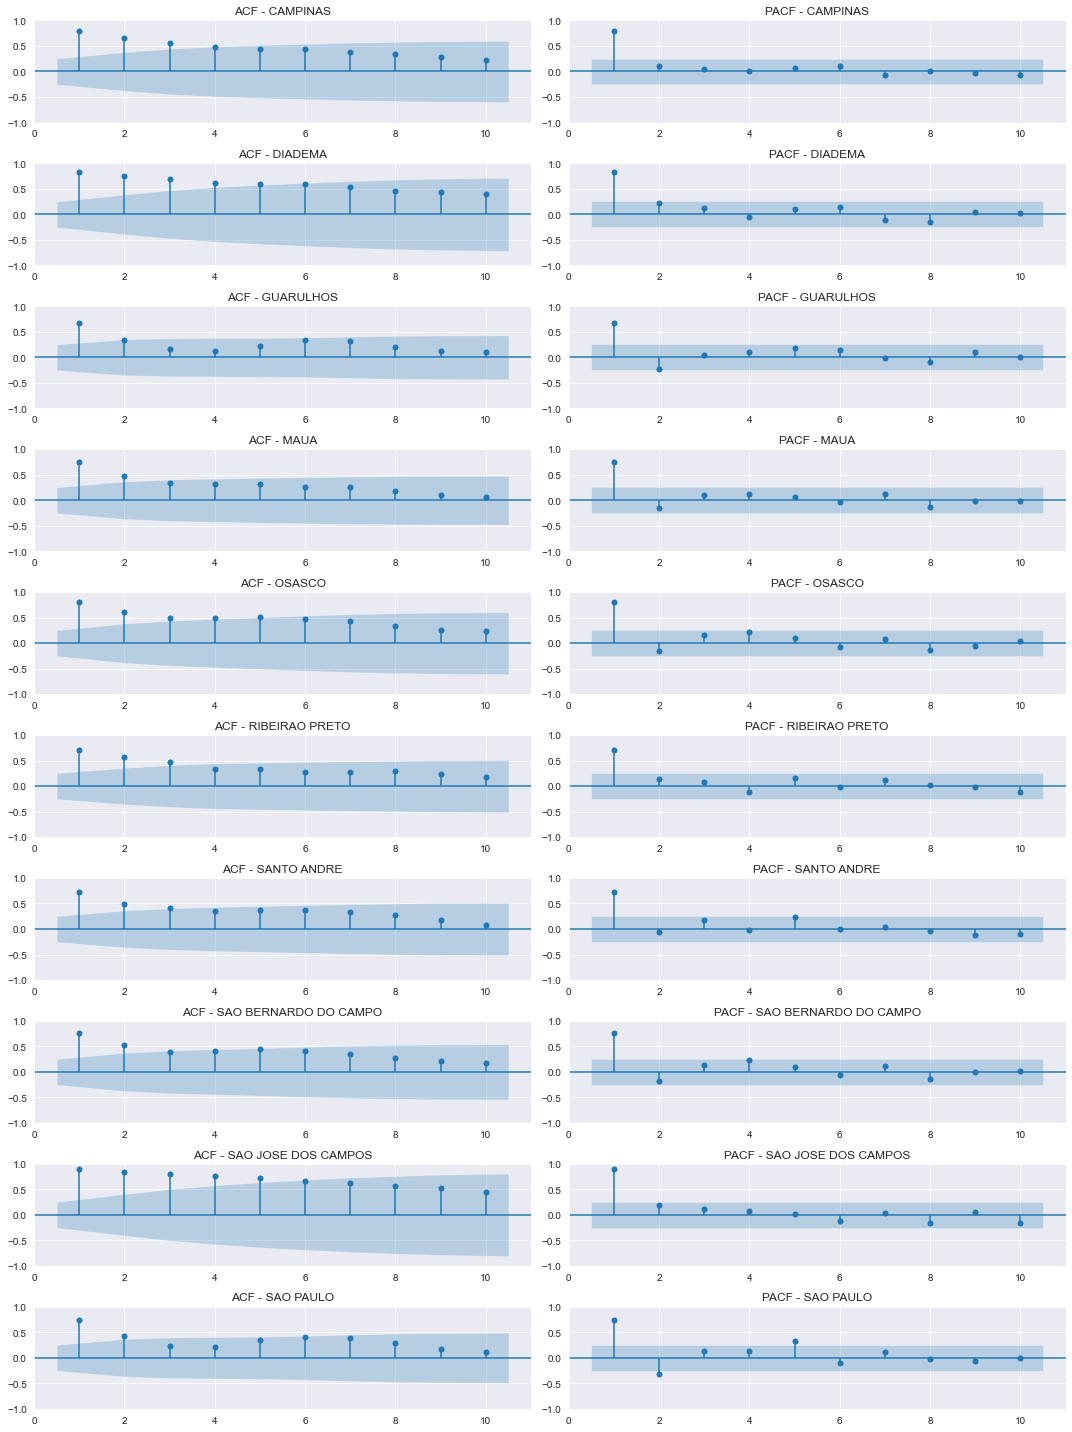

In [156]:
time_series_to_decomp['PANDEMIA'] = False
time_series_to_decomp.loc[time_series_to_decomp['year'].isin([2020,2021]),'PANDEMIA'] = True

plot_acf_pacf(df=time_series_to_decomp,nrows=10,filtros_lista=['cidade'],time_id_col='time_id')

### Curva de Autocorrelação - Dados Completos

Filtro ~Pandemia


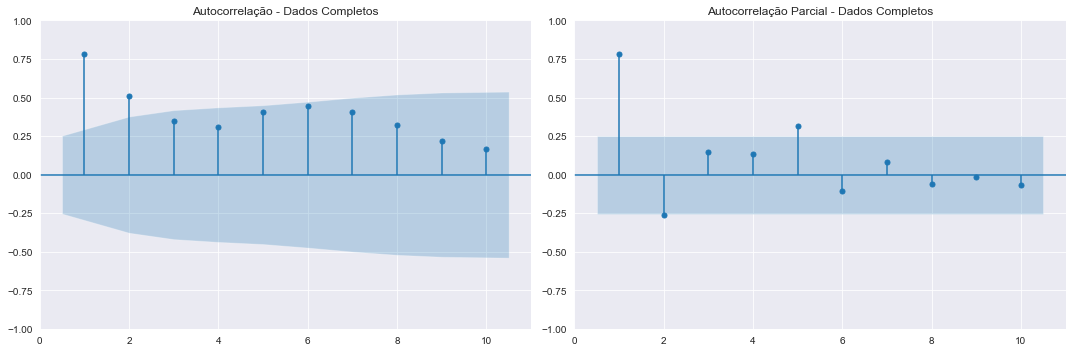

In [108]:
time_series_autocorr = time_series_to_decomp.groupby('time_id')['value'].sum().reset_index()
time_series_autocorr['year'] = time_series_autocorr['time_id'].apply(lambda x: x.year)
time_series_autocorr['PANDEMIA'] = False
time_series_autocorr.loc[time_series_autocorr['year'].isin([2020,2021]),'PANDEMIA'] = True

plot_acf_pacf(df=time_series_autocorr,nrows=1,filtros_lista=['~pandemia'],time_id_col='time_id',figsize=(15,5))

### ACF & PACF com dados estacionarizados

https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series

>>> CAMPINAS - DIFF (1)


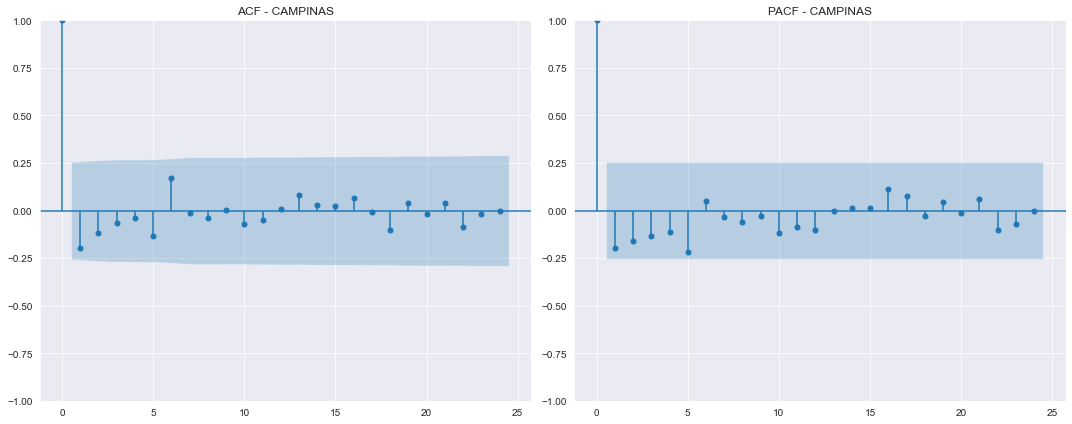

>>> DIADEMA - DIFF (1)


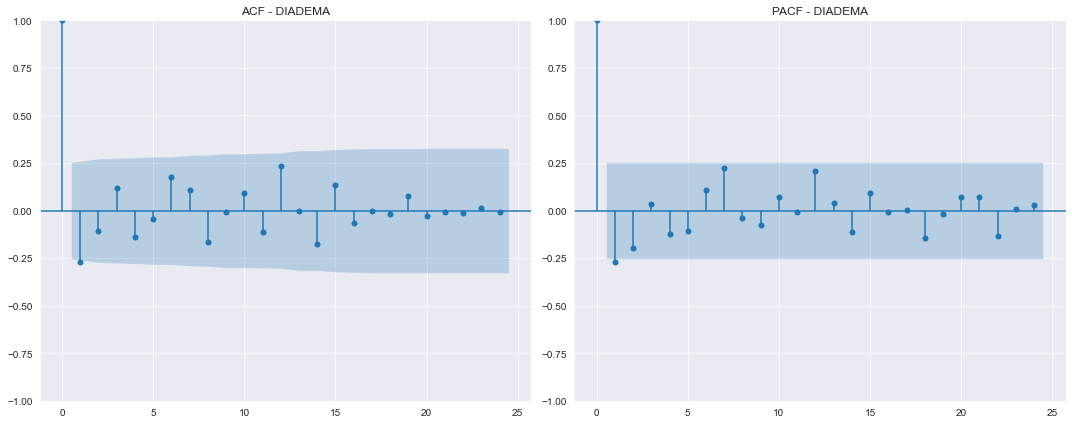

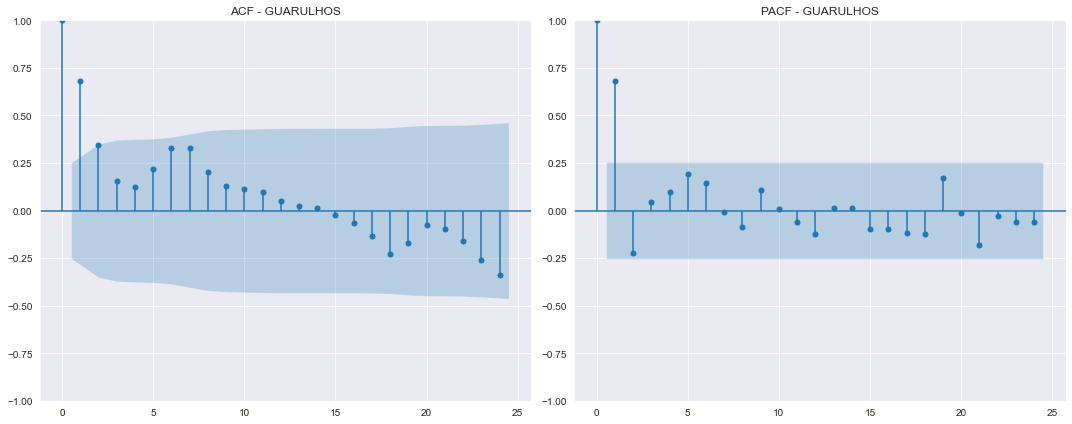

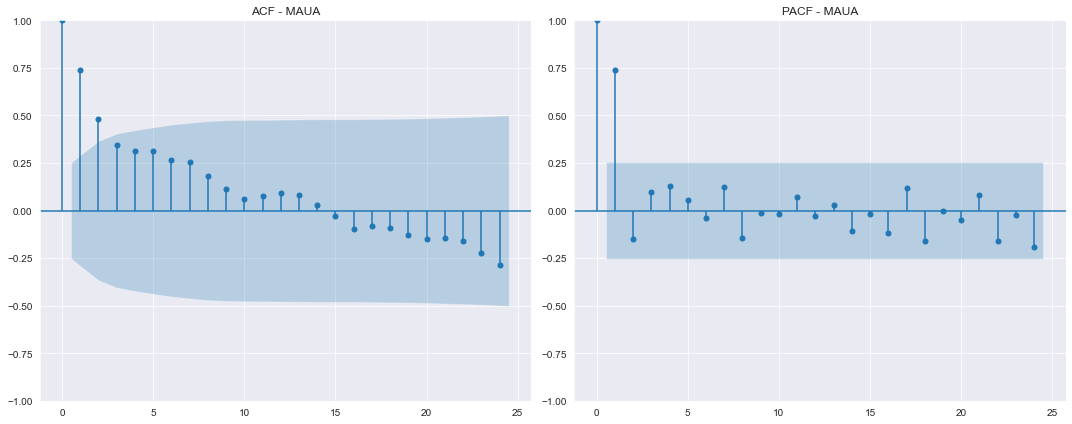

>>> OSASCO - DIFF (1)


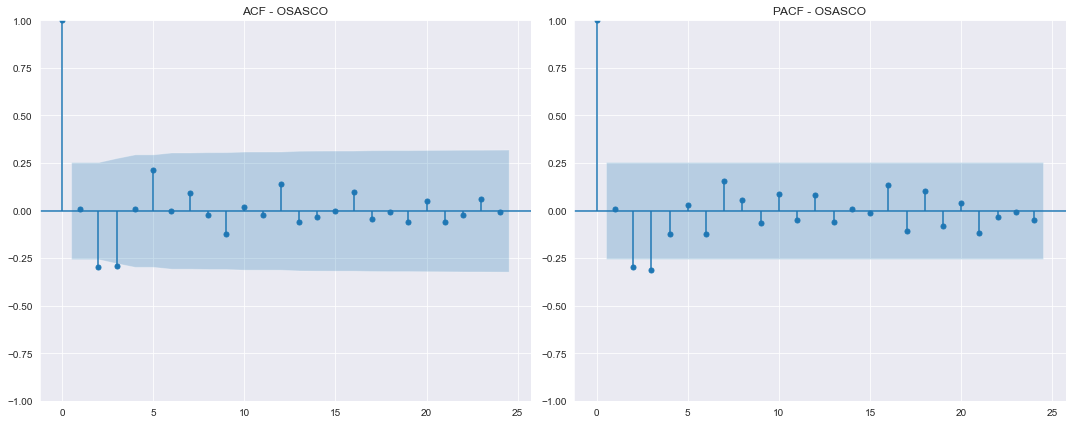

>>> RIBEIRAO PRETO - DIFF (1)


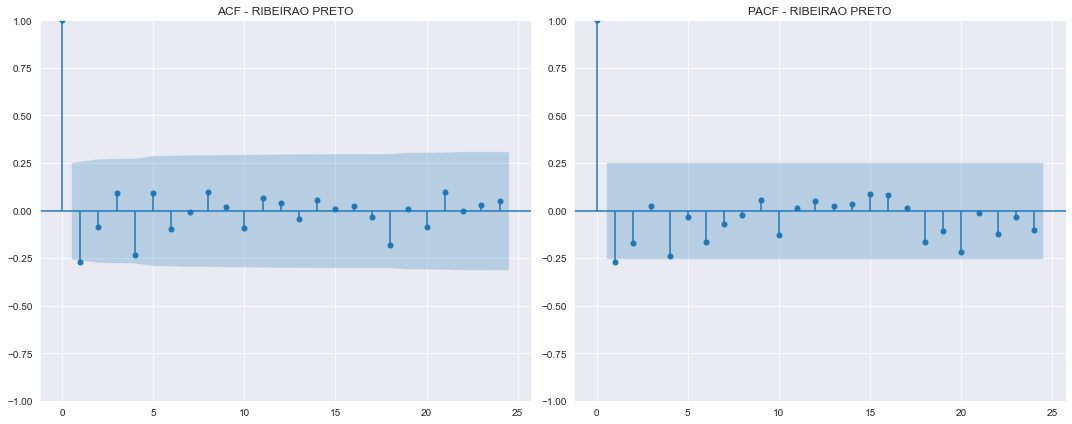

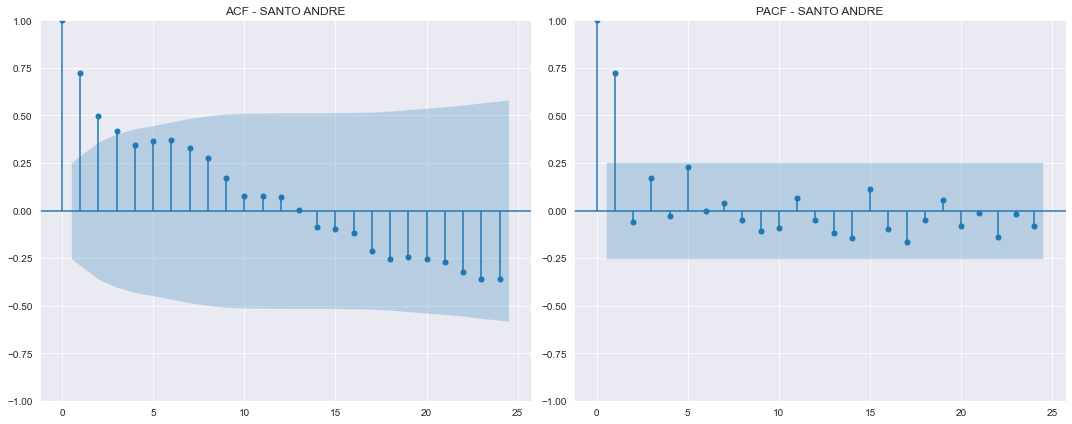

>>> SAO BERNARDO DO CAMPO - DIFF (1)


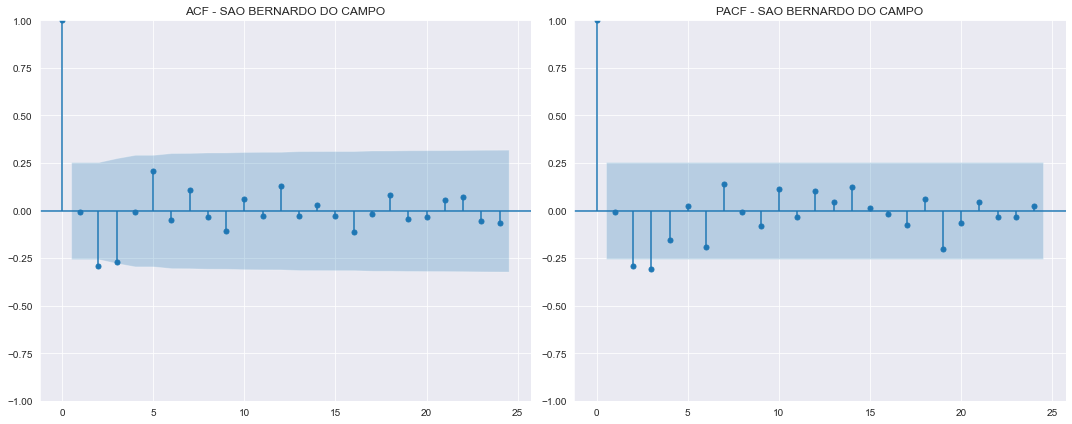

>>> SAO JOSE DOS CAMPOS - DIFF (1)


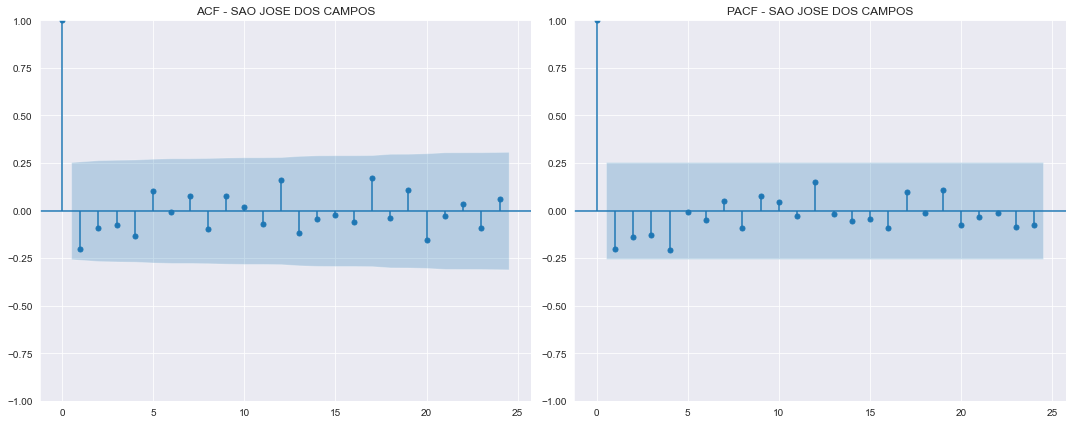

>>> SAO PAULO - DIFF (1)


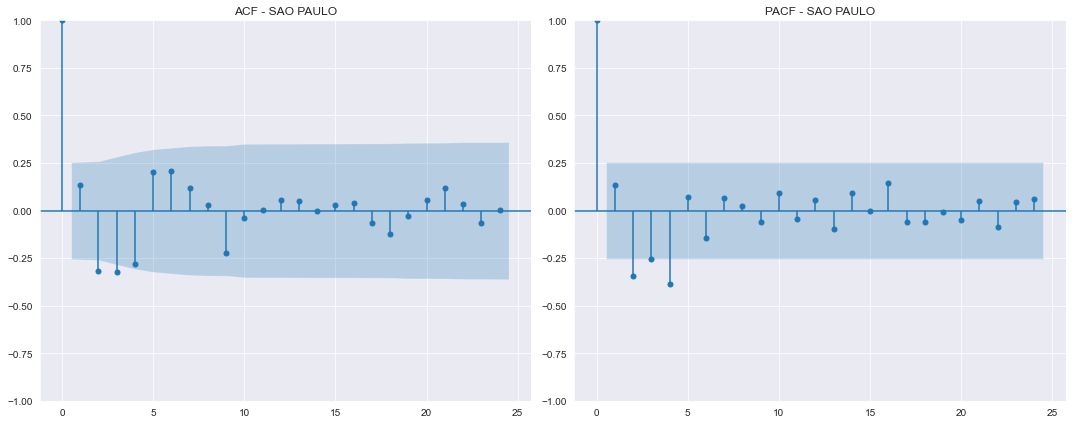

In [ ]:
def check_stationarity(series, verbose = False):
    # Adapted from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    if verbose:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        if verbose:
            print("\u001b[32mStationary\u001b[0m")
        return "Stationary"
    else:
        if verbose:
            print("\x1b[31mNon-stationary\x1b[0m")
        return "Non Stationary"
        
for cidade in time_series_to_decomp['CIDADE'].unique():
    
    filtro_cidade   = (time_series_to_decomp['CIDADE']==cidade)
    ts_df = time_series_to_decomp[
        filtro_cidade
    ].set_index('time_id')['value']
    
    test_num  = 0
    resultado = ''
    
    while resultado != "Stationary":
        test_num+=1
        resultado = check_stationarity(ts_df)
        
        if (test_num > 2) or (resultado=="Stationary"):
            break
        print(f'>>> {cidade} - DIFF ({test_num})')
        ts_df = ts_df.diff(periods=1).dropna()
    
    if resultado == "Stationary":
        plot_acf_pacf(df=ts_df,nrows=1,cidade=cidade,figsize=(15,6),lags=24)
    else:
        print(f'{cidade} - Não estacionarizável para até 2 diferenciações')

## SARIMA

### Endog

Non Stationary
Stationary


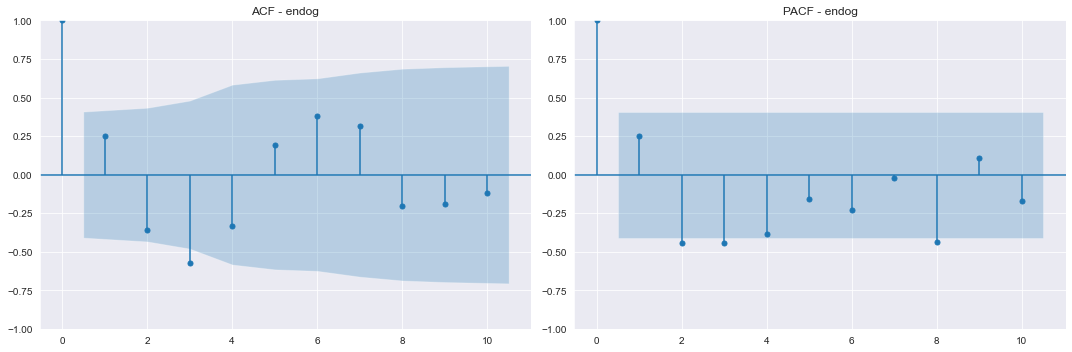

In [118]:
# endog_to_use = time_series_to_decomp[time_series_to_decomp['CIDADE']=='SAO PAULO'].set_index('time_id').loc[datetime.date(2018,1,1):datetime.date(2019,12,1),'value']
endog_to_use = time_series_to_decomp.groupby('time_id')['value'].sum()
endog_to_use = endog_to_use[(endog_to_use.index<=datetime.date(2019,12,1))]# | (endog_to_use.index >= datetime.date(2022,1,1))]
print(check_stationarity(endog_to_use))
endog_to_use = endog_to_use.diff(periods=1).dropna()
print(check_stationarity(endog_to_use))

plot_acf_pacf(df=endog_to_use,nrows=1,figsize=(15,5),cidade='endog')

### SARIMA MODEL

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            value   No. Observations:                   23
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -79.005
Date:                          Sat, 09 Sep 2023   AIC                            168.010
Time:                                  19:03:01   BIC                            169.523
Sample:                              02-01-2018   HQIC                           166.350
                                   - 12-01-2019                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0660      1.079     -0.061      0.951      -2.181       2.049
ma.L1         -0.9982     89.860     -0.011      0.991    -177.120     175.124
ar.S.L12      -0.9974      0.527     -1.894      0.058      -2.030       0.035
ma.S.L12      -0.4145    186.505     -0.002      0.998    -365.958     365.129
sigma2      4015.8003      0.067   5.98e+04      0.000    4015.669    4015.932
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.36   Prob(JB):                         0.77
Heteroskedasticity (H):               0.38   Skew:                             0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+23. Standard errors may be unstable.
"""

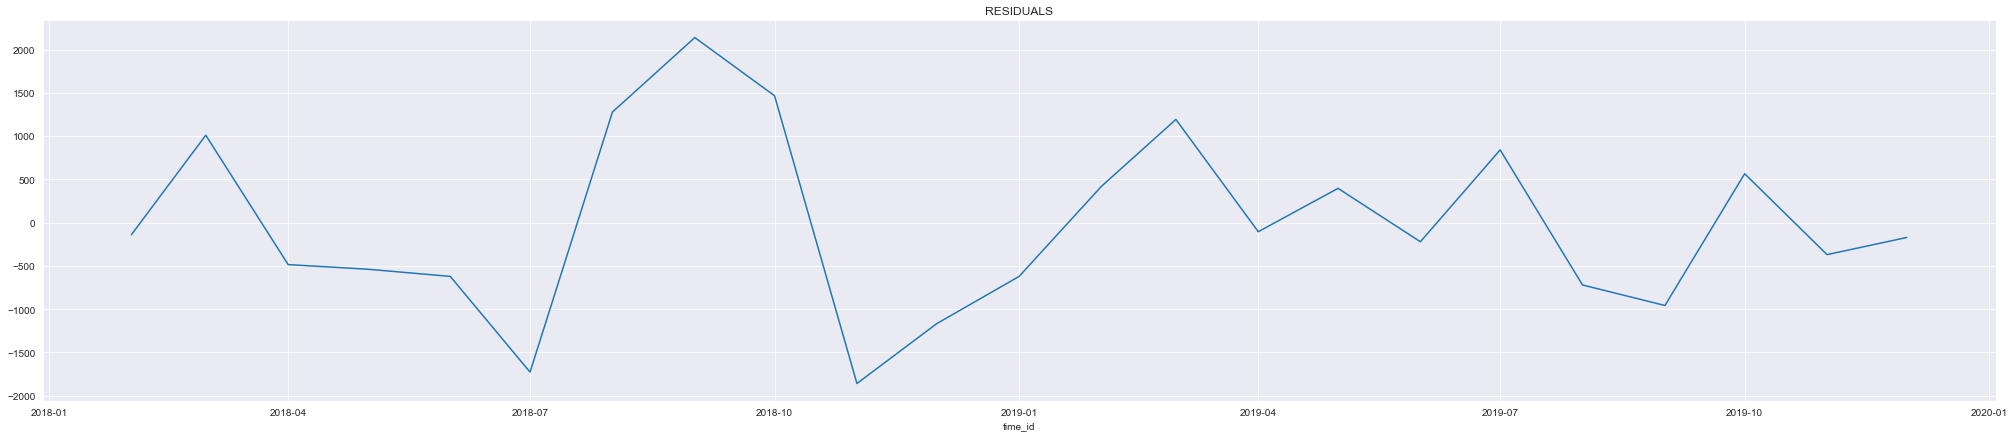

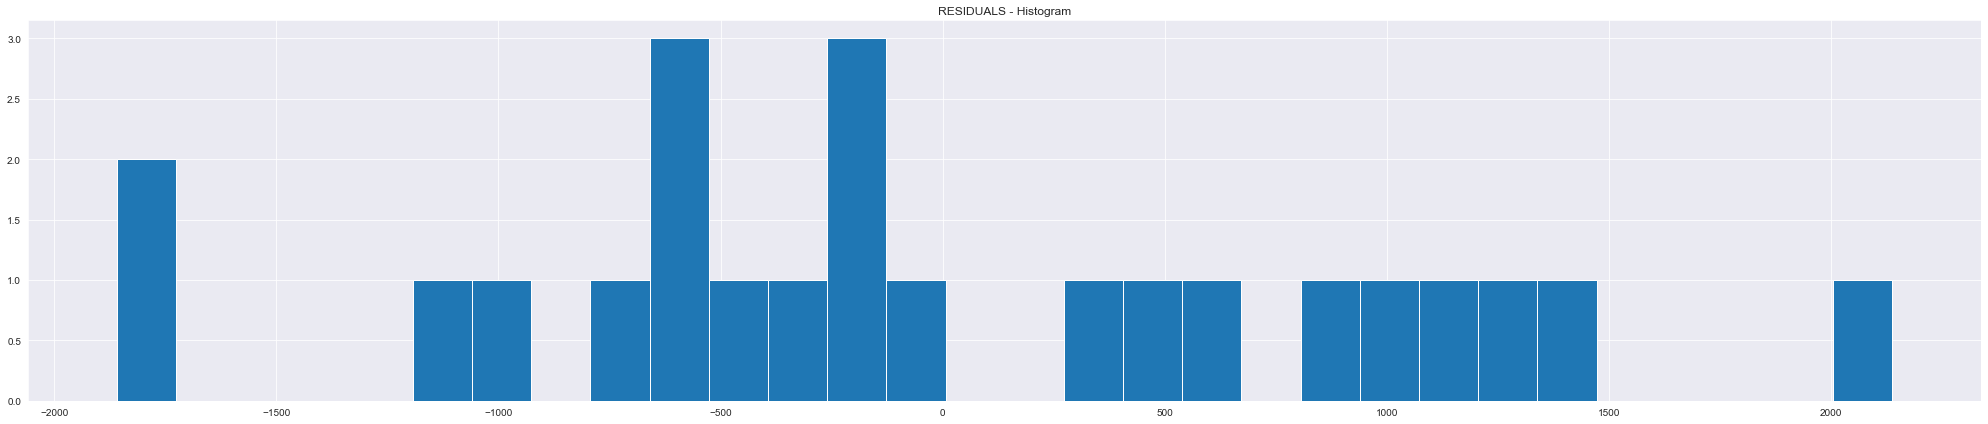

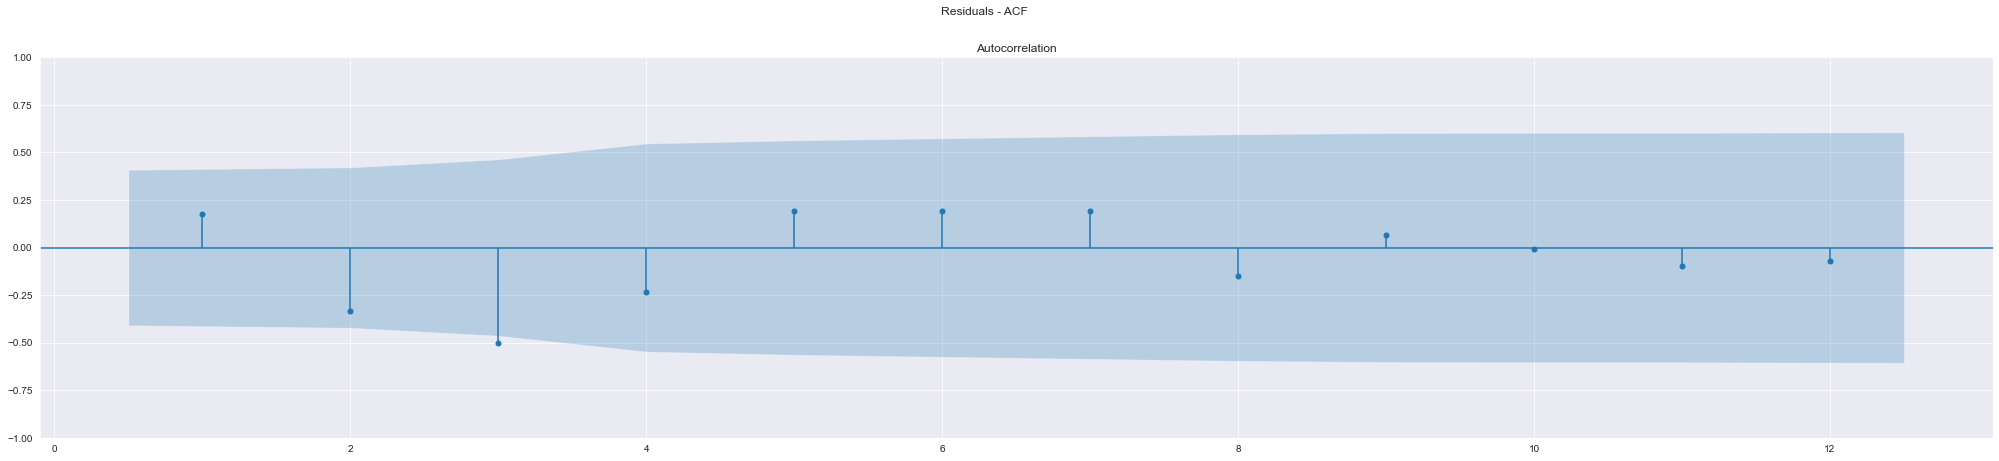

In [236]:
SARIMA = ARIMA(endog = endog_to_use,
                   order=(1,1,1),
                   seasonal_order=(1,1,1,12),
              ).fit() #trend : str{'n','c','t','ct'}

display(SARIMA.summary())

plt.figure(figsize=(35,7))
SARIMA.resid.plot()
plt.title('RESIDUALS')
plt.show()

plt.figure(figsize=(35,7))
SARIMA.resid.hist(bins=30)
plt.title('RESIDUALS - Histogram')
plt.show()

ax = plot_acf(SARIMA.resid,zero=False,lags=12)
ax.figure.set_figheight(7)
ax.figure.set_figwidth(35)
ax.figure.suptitle('Residuals - ACF');

### SARIMA FORECAST

Text(0.5, 1.0, 'Previsao ARIMA-Sazonal (FEV_2018-DEZ_2021)')

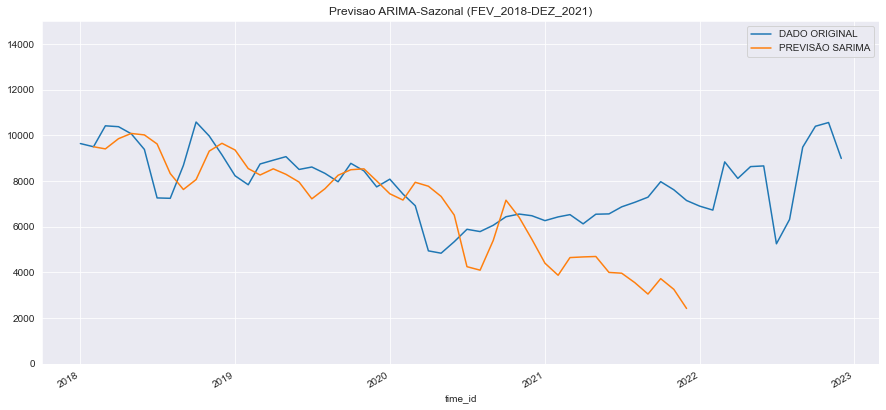

In [237]:
sarima_result = SARIMA.predict(start='2018-03-01',end='2021-12-01')
sarima_result.name = 'value'


sarima_result = pd.concat([
    pd.Series(index=[sarima_result.index[0]-datetime.timedelta(days=28)],name='value',data=time_series_to_decomp.groupby('time_id')['value'].sum().loc[datetime.date(2018,2,1)]),
    sarima_result]).cumsum()

ax = time_series_to_decomp.groupby('time_id')['value'].sum().plot(figsize=(15,7),label='DADO ORIGINAL')
sarima_result.plot(ax=ax,label='PREVISÃO SARIMA')
ax.legend()
ax.set_ylim((0,15e3))
ax.set_title('Previsao ARIMA-Sazonal (FEV_2018-DEZ_2021)')

In [27]:
##############################################################################################################################

In [28]:
# from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.stats.diagnostic import het_arch

# from lazypredict.Supervised import LazyRegressor
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split

In [238]:
teste = SARIMA.summary()
print(teste.as_latex)

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
Dep. Variable:                            value   No. Observations:                   23
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -79.005
Date:                          Sat, 09 Sep 2023   AIC                            168.010
Time:                                  19:03:37   BIC                            169.523
Sample:                              02-01-2018   HQIC                           166.350
                                   - 12-01-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0660      1.079     -0.061     

In [197]:
table1 = teste.tables[0]


\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &            value             & \textbf{  No. Observations:  } &    23    \\
\textbf{Model:}           & ARIMA(1, 1, 1)x(1, 1, 1, 12) & \textbf{  Log Likelihood     } & -79.005  \\
\textbf{Date:}            &       Sat, 09 Sep 2023       & \textbf{  AIC                } & 168.010  \\
\textbf{Time:}            &           18:41:59           & \textbf{  BIC                } & 169.523  \\
\textbf{Sample:}          &          02-01-2018          & \textbf{  HQIC               } & 166.350  \\
\textbf{}                 &         - 12-01-2019         & \textbf{                     } &          \\
\textbf{Covariance Type:} &             opg              & \textbf{                     } &          \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}


In [198]:
pd.read_table(table1.as_latex_tabular())

OSError: [Errno 22] Invalid argument: '\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}   &            value             & \\textbf{  No. Observations:  } &    23    \\\\\n\\textbf{Model:}           & ARIMA(1, 1, 1)x(1, 1, 1, 12) & \\textbf{  Log Likelihood     } & -79.005  \\\\\n\\textbf{Date:}            &       Sat, 09 Sep 2023       & \\textbf{  AIC                } & 168.010  \\\\\n\\textbf{Time:}            &           18:41:59           & \\textbf{  BIC                } & 169.523  \\\\\n\\textbf{Sample:}          &          02-01-2018          & \\textbf{  HQIC               } & 166.350  \\\\\n\\textbf{}                 &         - 12-01-2019         & \\textbf{                     } &          \\\\\n\\textbf{Covariance Type:} &             opg              & \\textbf{                     } &          \\\\\n\\bottomrule\n\\end{tabular}\n%\\caption{SARIMAX Results}\n\\end{center}'